 # Correlation Analysis: Tree Water Deficit vs Swiss EO Vegetation Health Index



 This notebook analyzes the correlation between:

 - **twd_norm**: Tree water deficit levels (0-10, continuous float values) "twd_norm ist ein Indikator, der direkt aus den Baumwasserdefizitdaten (Punktdendrometer) berechnet wird und mit Art- und Standort-spezifischen Faktoren normiert wird (keinen Vergangenheitsbezug). Je grösser, desto trockener.

 - **swissEOVHI**: Swiss EO Vegetation Health Index (0-100)



 **Data Validation Rules:**

 - Valid data: `swissEOMASK == 0` AND `swissEOVHI <= 100`

 - Invalid data: `swissEOMASK != 0` OR `swissEOVHI > 100`

 ## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# File path
inputfilepath = r"D:\Users\joan-sturm-w1\Documents\Treenet\\" # needs \\ at the end of the path


In [2]:
# Read the CSV file
try:
    # List all files in the directory ending with *swisseo.csv
    files = [f for f in os.listdir(inputfilepath) if f.endswith("swisseo.csv")]
    if not files:
        print("❌ Error: No files ending with *swisseo.csv found in the directory.")
        raise FileNotFoundError("No matching files found.")

    # Load all matching files into a single DataFrame
    dfs = []
    for file in files:
        filepath = os.path.join(inputfilepath, file)
        try:
            df_temp = pd.read_csv(filepath)
            dfs.append(df_temp)
            print(f"✓ Data loaded successfully from {file}. Shape: {df_temp.shape}")
        except Exception as e:
            print(f"❌ Error loading file {file}: {e}")
            raise

    # Concatenate all DataFrames
    df = pd.concat(dfs, ignore_index=True)
    print(f"\n✓ All files concatenated successfully. Combined Shape: {df.shape}")
    print(f"✓ Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    display(df.head())

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    raise


✓ Data loaded successfully from TN_2017_swisseo.csv. Shape: (30114, 14)
✓ Data loaded successfully from TN_2018_swisseo.csv. Shape: (30744, 14)
✓ Data loaded successfully from TN_2019_swisseo.csv. Shape: (36456, 14)
✓ Data loaded successfully from TN_2020_swisseo.csv. Shape: (38006, 14)
✓ Data loaded successfully from TN_2021_swisseo.csv. Shape: (47311, 14)
✓ Data loaded successfully from TN_2022_swisseo.csv. Shape: (74613, 14)
✓ Data loaded successfully from TN_2023_swisseo.csv. Shape: (90055, 14)

✓ All files concatenated successfully. Combined Shape: (347299, 14)
✓ Columns: ['series_id', 'doy', 'year', 'twd_norm', 'signalTWD_norm', 'tree_xcor', 'tree_ycor', 'tree_altitude', 'tree_gs', 'site_name', 'measure_point', 'DATETIME', 'swissEOVHI', 'swissEOMASK']

First few rows:


series_id  doy  year  twd_norm  signalTWD_norm  tree_xcor  tree_ycor  \
0         73    1  2017       0.0               1   8.454529  47.362910   
1       1167    1  2017       0.0               1   9.066944  47.165802   
2        120    1  2017       0.0               1   7.677172  47.460875   
3       1271    1  2017       0.0               1   9.623876  46.674708   
4        853    1  2017       0.0               1   8.535689  47.683560   

   tree_altitude             tree_gs            site_name  \
0        542.529     Fagus sylvatica   Birmensdorf-Forest   
1        715.359  Fraxinus excelsior         Schaenis-low   
2        659.681     Quercus petraea        Bueren-Forest   
3       1199.000    Pinus sylvestris         Surava-North   
4        583.665     Quercus petraea  Neunkirch-Southeast   

                                       measure_point    DATETIME  swissEOVHI  \
0  birmensdorf-forest_dendrometer_µm_buche-49_0_1...  2017-01-01         120   
1  schaenis-low_dendrometer_µm_baum-1202_0_1.5_no...  2017-01-01         120   
2  bueren-forest_dendrometer_µm_n1_0_1.5_northwes...  2017-01-01         120   
3  surava-north_dendrometer_µm_föhre-sc4_0_1.5_ea...  2017-01-01         120   
4  neunkirch-southeast_dendrometer_µm_eiche-1_0_1...  2017-01-01         120   

   swissEOMASK  
0          120  
1          120  
2          120  
3          120  
4          120

 ## 2. Data Exploration and Quality Assessment

In [3]:
# Basic data info
print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nData types:")
display(df.dtypes)


DATA OVERVIEW
Dataset shape: (347299, 14)
Memory usage: 142.16 MB

Data types:


series_id           int64
doy                 int64
year                int64
twd_norm          float64
signalTWD_norm      int64
tree_xcor         float64
tree_ycor         float64
tree_altitude     float64
tree_gs            object
site_name          object
measure_point      object
DATETIME           object
swissEOVHI          int64
swissEOMASK         int64
dtype: object

In [4]:
# Check for missing values
print("="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)
missing_summary = df.isnull().sum()
missing_pct = (missing_summary / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print("Missing values per column:")
display(missing_df[missing_df['Missing_Count'] > 0])


MISSING VALUES ANALYSIS
Missing values per column:


Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []

In [5]:
# Analyze our key variables before cleaning
print("="*60)
print("KEY VARIABLES - RAW DATA ANALYSIS")
print("="*60)

key_vars = ['twd_norm', 'swissEOVHI', 'swissEOMASK']

# Filter data for DOY between 90 and 274 (April 1 to September 30 - Growing Season)
DOY_start = 1
DOY_end = 365
print("Applying DOY filter: 90-274 (April 1 to September 30)")
print(f"Original dataset: {len(df)} rows")
df_filtered = df[(df['doy'] >= DOY_start) & (df['doy'] <= DOY_end)]
print(f"After DOY filter: {len(df_filtered)} rows ({(len(df_filtered)/len(df))*100:.1f}% retained)")

print(f"\nDOY distribution in filtered data:")
print(f"DOY range: {df_filtered['doy'].min()} to {df_filtered['doy'].max()}")
print(f"DOY statistics:")
print(df_filtered['doy'].describe())

for var in key_vars:
    if var in df_filtered.columns:
        print(f"\n{var} - Filtered Statistics (DOY {DOY_start}-{DOY_end}):")
        print(df_filtered[var].describe())

        # Special analysis for different variables
        if var == 'twd_norm':
            print(f"Range: {df_filtered[var].min():.3f} to {df_filtered[var].max():.3f}")
            print(f"Expected range: 0-10 ✓" if df_filtered[var].min() >= 0 and df_filtered[var].max() <= 10 else f"⚠️ Values outside expected range")
            # Show distribution in bins
            bins = np.arange(0, 11, 1)  # 0-1, 1-2, ..., 9-10
            hist, bin_edges = np.histogram(df_filtered[var], bins=bins)
            print("Distribution by integer ranges:")
            for i in range(len(hist)):
                if hist[i] > 0:
                    print(f"  {bin_edges[i]:.0f}-{bin_edges[i+1]:.0f}: {hist[i]} values ({hist[i]/len(df_filtered)*100:.1f}%)")

        elif var == 'swissEOMASK':
            mask_counts = df_filtered[var].value_counts().sort_index()
            print(f"swissEOMASK value counts:")
            for value, count in mask_counts.items():
                pct = (count / len(df_filtered)) * 100
                print(f"  {value}: {count} ({pct:.1f}%)")

        elif var == 'swissEOVHI':
            print(f"Values > 100: {(df_filtered[var] > 100).sum()} ({((df_filtered[var] > 100).sum() / len(df_filtered)) * 100:.1f}%)")
            print(f"Values <= 100: {(df_filtered[var] <= 100).sum()} ({((df_filtered[var] <= 100).sum() / len(df_filtered)) * 100:.1f}%)")


KEY VARIABLES - RAW DATA ANALYSIS
Applying DOY filter: 90-274 (April 1 to September 30)
Original dataset: 347299 rows
After DOY filter: 347299 rows (100.0% retained)

DOY distribution in filtered data:
DOY range: 1 to 365
DOY statistics:
count    347299.000000
mean        186.122995
std         105.014386
min           1.000000
25%          96.000000
50%         187.000000
75%         278.000000
max         365.000000
Name: doy, dtype: float64

twd_norm - Filtered Statistics (DOY 1-365):
count    347299.000000
mean          0.816607
std           1.042533
min           0.000000
25%           0.033918
50%           0.462032
75%           1.195580
max           9.996126
Name: twd_norm, dtype: float64
Range: 0.000 to 9.996
Expected range: 0-10 ✓
Distribution by integer ranges:
  0-1: 242195 values (69.7%)
  1-2: 66013 values (19.0%)
  2-3: 23767 values (6.8%)
  3-4: 9122 values (2.6%)
  4-5: 3188 values (0.9%)
  5-6: 1514 values (0.4%)
  6-7: 1022 values (0.3%)
  7-8: 316 values (0.1%)
  

Values <= 100: 117991 (34.0%)

swissEOMASK - Filtered Statistics (DOY 1-365):
count    347299.000000
mean        110.451585
std          61.078892
min           0.000000
25%         120.000000
50%         120.000000
75%         120.000000
max         255.000000
Name: swissEOMASK, dtype: float64
swissEOMASK value counts:
  0: 39100 (11.3%)
  1: 19140 (5.5%)
  120: 261996 (75.4%)
  255: 27063 (7.8%)


 ## 3. Data Validation and Cleaning

In [6]:
print("="*60)
print("DATA VALIDATION AND CLEANING")
print("="*60)

# Apply validation rules to the DOY-filtered data
print("Applying validation rules to DOY-filtered data:")
print("✓ Valid data: swissEOMASK == 0 AND swissEOVHI <= 100")
print("✗ Invalid data: swissEOMASK != 0 OR swissEOVHI > 100")

# Count data before cleaning
total_filtered_rows = len(df_filtered)
print(f"\nDOY-filtered dataset: {total_filtered_rows} rows")

# Check validation conditions
mask_valid = df_filtered['swissEOMASK'] == 0
vhi_valid = df_filtered['swissEOVHI'] <= 100
both_valid = mask_valid & vhi_valid

print(f"Rows with swissEOMASK == 0: {mask_valid.sum()} ({(mask_valid.sum()/total_filtered_rows)*100:.1f}%)")
print(f"Rows with swissEOVHI <= 100: {vhi_valid.sum()} ({(vhi_valid.sum()/total_filtered_rows)*100:.1f}%)")
print(f"Rows meeting both conditions: {both_valid.sum()} ({(both_valid.sum()/total_filtered_rows)*100:.1f}%)")

# Create cleaned dataset
df_valid = df_filtered[both_valid].copy()

# Remove rows with missing values in key analysis variables
analysis_vars = ['twd_norm', 'swissEOVHI']
df_clean = df_valid.dropna(subset=analysis_vars)

print(f"\nAfter validation: {len(df_valid)} rows")
print(f"After removing missing values in analysis variables: {len(df_clean)} rows")
print(f"Final dataset for analysis: {len(df_clean)} rows ({(len(df_clean)/total_filtered_rows)*100:.1f}% of DOY-filtered data)")
print(f"Overall retention from original data: {(len(df_clean)/len(df))*100:.1f}%")


DATA VALIDATION AND CLEANING
Applying validation rules to DOY-filtered data:
✓ Valid data: swissEOMASK == 0 AND swissEOVHI <= 100
✗ Invalid data: swissEOMASK != 0 OR swissEOVHI > 100

DOY-filtered dataset: 347299 rows
Rows with swissEOMASK == 0: 39100 (11.3%)
Rows with swissEOVHI <= 100: 117991 (34.0%)
Rows meeting both conditions: 25016 (7.2%)

After validation: 25016 rows
After removing missing values in analysis variables: 25016 rows
Final dataset for analysis: 25016 rows (7.2% of DOY-filtered data)
Overall retention from original data: 7.2%


In [7]:
# Validate the cleaned data ranges
print("="*60)
print("CLEANED DATA VALIDATION")
print("="*60)

print("twd_norm (water deficit levels):")
print(f"  Range: {df_clean['twd_norm'].min():.3f} to {df_clean['twd_norm'].max():.3f}")
print(f"  Expected: -2 to 10 ✓" if df_clean['twd_norm'].min() >= -2 and df_clean['twd_norm'].max() <= 10 else f"  ⚠️ Values outside expected range")
print(f"  Data type: {df_clean['twd_norm'].dtype}")

print(f"\nswissEOVHI (vegetation health index):")
print(f"  Range: {df_clean['swissEOVHI'].min():.1f} to {df_clean['swissEOVHI'].max():.1f}")
print(f"  Expected: 0-100 ✓" if df_clean['swissEOVHI'].min() >= 0 and df_clean['swissEOVHI'].max() <= 100 else f"  ⚠️ Values outside expected range")

print(f"\nswissEOMASK (should all be 0):")
print(f"  Unique values: {sorted(df_clean['swissEOMASK'].unique())}")
print(f"  All zeros: ✓" if list(df_clean['swissEOMASK'].unique()) == [0] else f"  ⚠️ Non-zero values found")


CLEANED DATA VALIDATION
twd_norm (water deficit levels):
  Range: 0.000 to 9.681
  Expected: -2 to 10 ✓
  Data type: float64

swissEOVHI (vegetation health index):
  Range: 0.0 to 100.0
  Expected: 0-100 ✓

swissEOMASK (should all be 0):
  Unique values: [0]
  All zeros: ✓


 ## 4. Descriptive Statistics

In [8]:
print("="*60)
print("DESCRIPTIVE STATISTICS - CLEANED DATA")
print("="*60)

# Overall statistics
print("Overall Statistics:")
display(df_clean[['twd_norm', 'swissEOVHI']].describe())

# Create bins for twd_norm to analyze patterns
print("\nswissEOVHI Statistics by TWD Level Bins:")
# Create bins: 0-0.17, 0.171-0.42, 0.421-10
df_clean['twd_bin'] = pd.cut(df_clean['twd_norm'], bins=[0, 0.17, 0.42, 10],
                             labels=['unterdurchschnittlich (0-0.17)', 'überdurchschnittlich (0.171-0.42)', 'aussergewöhnlich (0.421-10)'],
                             include_lowest=True)

bin_stats = df_clean.groupby('twd_bin', observed=False)['swissEOVHI'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(2)
bin_stats.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Max', 'Median']
display(bin_stats)

# Also show continuous statistics
print("\nCorrelation with continuous twd_norm values:")
print(f"twd_norm range: {df_clean['twd_norm'].min():.3f} - {df_clean['twd_norm'].max():.3f}")
print(f"twd_norm mean: {df_clean['twd_norm'].mean():.3f} ± {df_clean['twd_norm'].std():.3f}")


DESCRIPTIVE STATISTICS - CLEANED DATA
Overall Statistics:


twd_norm    swissEOVHI
count  25016.000000  25016.000000
mean       0.977576     52.447074
std        1.099698     23.609462
min        0.000000      0.000000
25%        0.097931     37.000000
50%        0.677235     53.000000
75%        1.457391     69.000000
max        9.681293    100.000000


swissEOVHI Statistics by TWD Level Bins:


Count   Mean  Std Dev  Min  Max  Median
twd_bin                                                                   
unterdurchschnittlich (0-0.17)      7238  55.48    23.19    0  100    57.0
überdurchschnittlich (0.171-0.42)   2773  55.04    23.58    0  100    56.0
aussergewöhnlich (0.421-10)        15005  50.51    23.62    0  100    51.0


Correlation with continuous twd_norm values:
twd_norm range: 0.000 - 9.681
twd_norm mean: 0.978 ± 1.100


 ## 5. Correlation Analysis

In [9]:
print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Extract variables for analysis
twd_values = df_clean['twd_norm']
swiss_eovhi = df_clean['swissEOVHI']

# Calculate correlations
pearson_corr, pearson_p = pearsonr(twd_values, swiss_eovhi)
spearman_corr, spearman_p = spearmanr(twd_values, swiss_eovhi)

print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"Pearson p-value: {pearson_p:.4f}")
print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
print(f"Spearman p-value: {spearman_p:.4f}")

# Interpretation function
def interpret_correlation(corr):
    abs_corr = abs(corr)
    if abs_corr >= 0.7:
        strength = "strong"
    elif abs_corr >= 0.3:
        strength = "moderate"
    elif abs_corr >= 0.1:
        strength = "weak"
    else:
        strength = "very weak/negligible"

    direction = "positive" if corr > 0 else "negative"
    return f"{strength} {direction}"

print(f"\nInterpretation:")
print(f"Pearson: {interpret_correlation(pearson_corr)} correlation")
print(f"Spearman: {interpret_correlation(spearman_corr)} correlation")

significance_level = 0.05
print(f"\nStatistical Significance (α = {significance_level}):")
print(f"Pearson: {'Significant' if pearson_p < significance_level else 'Not significant'} (p = {pearson_p:.4f})")
print(f"Spearman: {'Significant' if spearman_p < significance_level else 'Not significant'} (p = {spearman_p:.4f})")


CORRELATION ANALYSIS
Pearson correlation coefficient: -0.1277
Pearson p-value: 0.0000
Spearman correlation coefficient: -0.1323
Spearman p-value: 0.0000

Interpretation:
Pearson: weak negative correlation
Spearman: weak negative correlation

Statistical Significance (α = 0.05):
Pearson: Significant (p = 0.0000)
Spearman: Significant (p = 0.0000)


 ## 6. Visualization

D:\Users\joan-sturm-w1\AppData\Local\Temp\1\ipykernel_9436\1684193655.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=[label.replace(' ', '\n') for label in df_clean['twd_bin'].cat.categories],


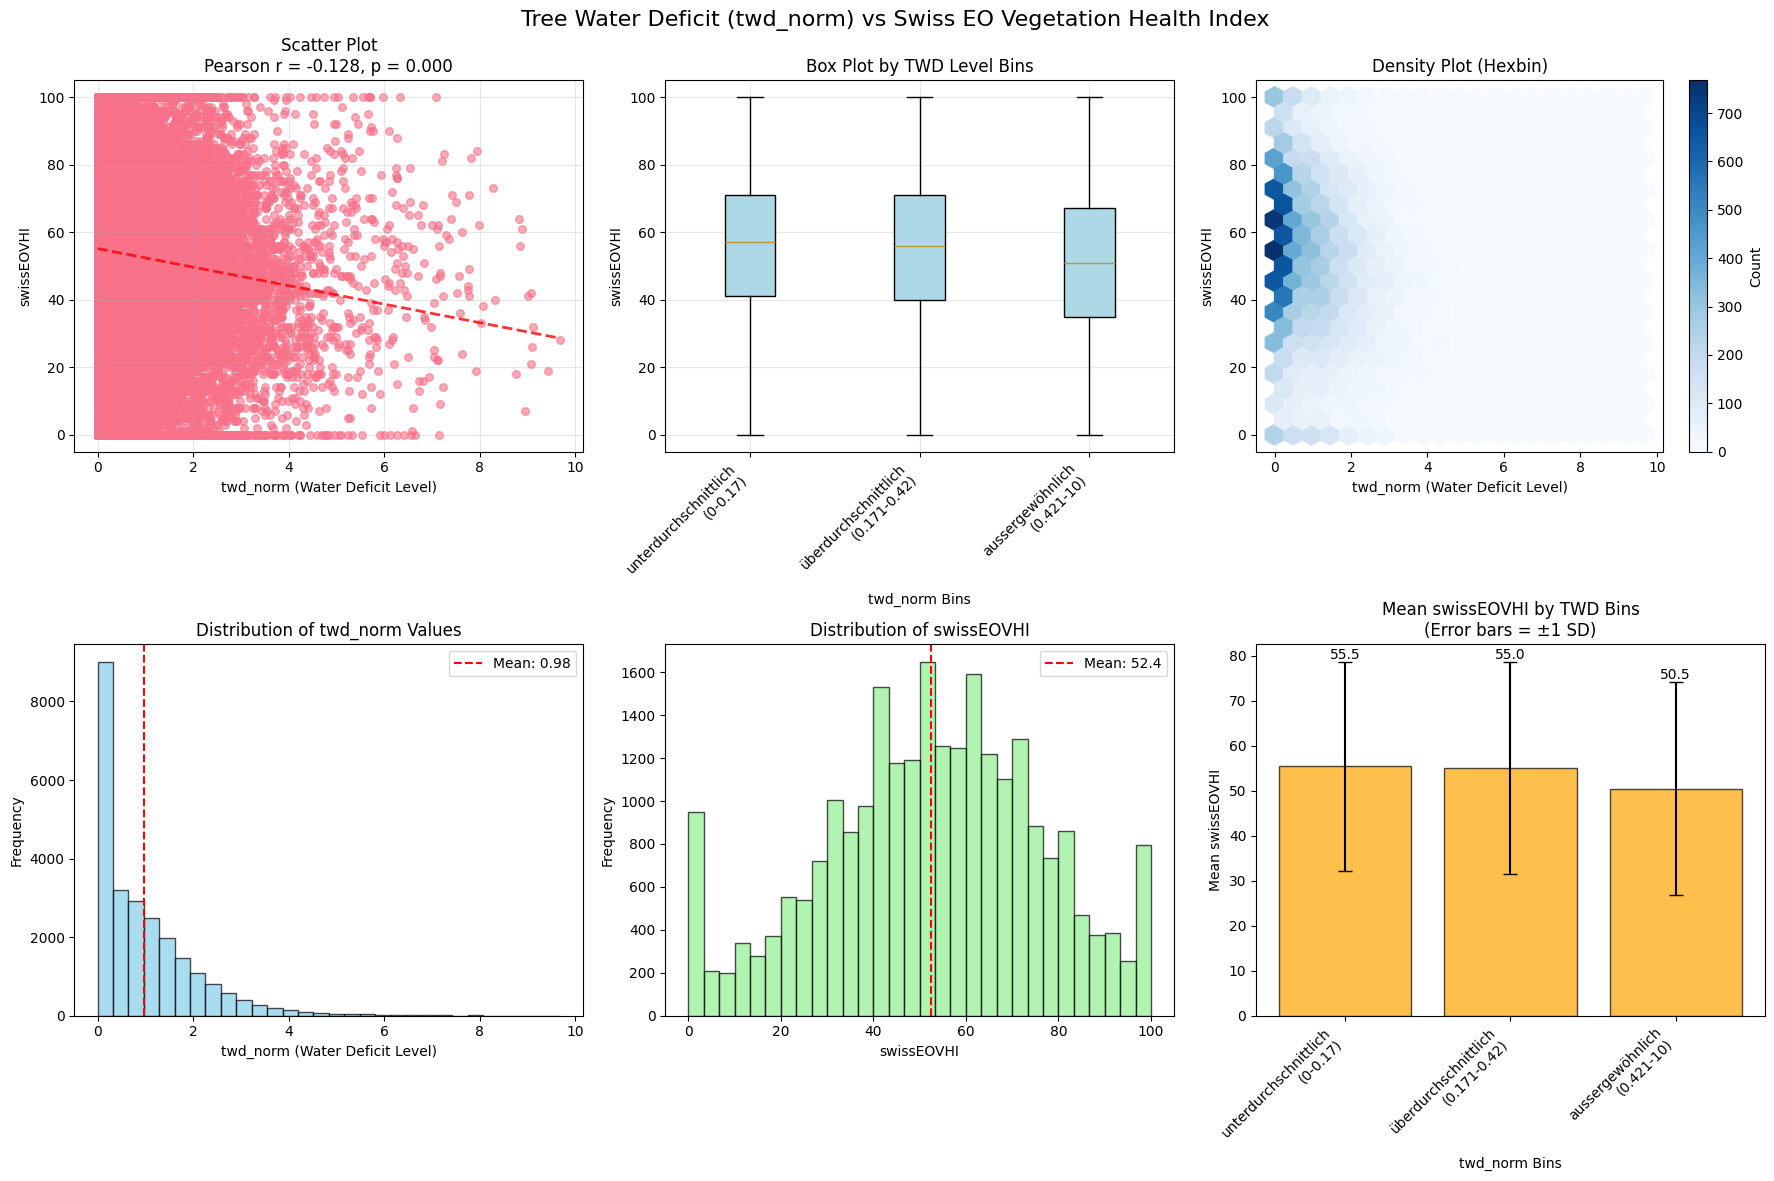

In [10]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Tree Water Deficit (twd_norm) vs Swiss EO Vegetation Health Index', fontsize=16, y=0.98)

# 1. Scatter plot
ax1 = axes[0, 0]
ax1.scatter(twd_values, swiss_eovhi, alpha=0.6, s=30)
ax1.set_xlabel('twd_norm (Water Deficit Level)')
ax1.set_ylabel('swissEOVHI')
ax1.set_title(f'Scatter Plot\nPearson r = {pearson_corr:.3f}, p = {pearson_p:.3f}')
ax1.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(twd_values, swiss_eovhi, 1)
p = np.poly1d(z)
x_trend = np.linspace(twd_values.min(), twd_values.max(), 100)
ax1.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

# 2. Box plot by binned twd_norm
ax2 = axes[0, 1]
box_data = [df_clean[df_clean['twd_bin'] == bin_label]['swissEOVHI'].values
            for bin_label in df_clean['twd_bin'].cat.categories]
bp = ax2.boxplot(box_data, labels=[label.replace(' ', '\n') for label in df_clean['twd_bin'].cat.categories],
                 patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax2.set_xlabel('twd_norm Bins')
ax2.set_ylabel('swissEOVHI')
ax2.set_title('Box Plot by TWD Level Bins')
ax2.grid(True, alpha=0.3)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Hexbin plot for density
ax3 = axes[0, 2]
hb = ax3.hexbin(twd_values, swiss_eovhi, gridsize=20, cmap='Blues')
ax3.set_xlabel('twd_norm (Water Deficit Level)')
ax3.set_ylabel('swissEOVHI')
ax3.set_title('Density Plot (Hexbin)')
plt.colorbar(hb, ax=ax3, label='Count')

# 4. Histogram of twd_norm
ax4 = axes[1, 0]
ax4.hist(twd_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax4.set_xlabel('twd_norm (Water Deficit Level)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of twd_norm Values')
ax4.axvline(twd_values.mean(), color='red', linestyle='--', label=f'Mean: {twd_values.mean():.2f}')
ax4.legend()

# 5. Histogram of swissEOVHI
ax5 = axes[1, 1]
ax5.hist(swiss_eovhi, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
ax5.set_xlabel('swissEOVHI')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of swissEOVHI')
ax5.axvline(swiss_eovhi.mean(), color='red', linestyle='--', label=f'Mean: {swiss_eovhi.mean():.1f}')
ax5.legend()

# 6. Mean and error bars by bins
ax6 = axes[1, 2]
bin_means = bin_stats['Mean']
bin_stds = bin_stats['Std Dev']
x_pos = range(len(bin_means))
bars = ax6.bar(x_pos, bin_means.values, yerr=bin_stds.values, capsize=5,
               alpha=0.7, color='orange', edgecolor='black')
ax6.set_xlabel('twd_norm Bins')
ax6.set_ylabel('Mean swissEOVHI')
ax6.set_title('Mean swissEOVHI by TWD Bins\n(Error bars = ±1 SD)')
ax6.set_xticks(x_pos)
ax6.set_xticklabels([label.replace(' ', '\n') for label in bin_means.index], rotation=45, ha='right')

# Add value labels on bars
for bar, mean_val in zip(bars, bin_means.values):
    height = bar.get_height()
    if not np.isnan(height):
        ax6.text(bar.get_x() + bar.get_width()/2., height + bin_stds.iloc[bars.index(bar)],
                 f'{mean_val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


 ## 7. Statistical Tests

In [11]:
print("="*60)
print("ADDITIONAL STATISTICAL TESTS")
print("="*60)

# ANOVA test to check if means differ significantly across TWD bins
from scipy.stats import f_oneway

twd_groups = [df_clean[df_clean['twd_bin'] == bin_label]['swissEOVHI'].values
              for bin_label in df_clean['twd_bin'].cat.categories
              if len(df_clean[df_clean['twd_bin'] == bin_label]) > 0]

if len(twd_groups) > 1:
    f_stat, anova_p = f_oneway(*twd_groups)
    print(f"One-way ANOVA (comparing TWD bins):")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {anova_p:.4f}")
    print(f"Result: {'Significant differences' if anova_p < 0.05 else 'No significant differences'} between TWD bin means")

    # Kruskal-Wallis test (non-parametric alternative)
    from scipy.stats import kruskal
    kw_stat, kw_p = kruskal(*twd_groups)
    print(f"\nKruskal-Wallis test (non-parametric):")
    print(f"H-statistic: {kw_stat:.4f}")
    print(f"p-value: {kw_p:.4f}")
    print(f"Result: {'Significant differences' if kw_p < 0.05 else 'No significant differences'} between TWD bin distributions")
else:
    print("Insufficient data for ANOVA/Kruskal-Wallis tests")

# Linear regression analysis
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(twd_values, swiss_eovhi)
print(f"\nLinear Regression Analysis:")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"Standard error: {std_err:.4f}")
print(f"Regression equation: swissEOVHI = {intercept:.2f} + {slope:.4f} × twd_norm")


ADDITIONAL STATISTICAL TESTS
One-way ANOVA (comparing TWD bins):
F-statistic: 128.1824
p-value: 0.0000
Result: Significant differences between TWD bin means

Kruskal-Wallis test (non-parametric):
H-statistic: 260.3840
p-value: 0.0000
Result: Significant differences between TWD bin distributions

Linear Regression Analysis:
Slope: -2.7425
Intercept: 55.1281
R-squared: 0.0163
Standard error: 0.1346
Regression equation: swissEOVHI = 55.13 + -2.7425 × twd_norm


 ## 8. Site-Specific Analysis

SITE-SPECIFIC ANALYSIS
Site-specific correlations (sites with ≥10 observations):


Site  N_Observations  Pearson_r  Pearson_p  \
0                   Chippis-East            1005    -0.1411     0.0000   
1            Pfynwald-Irrigation            1368    -0.0999     0.0002   
2                Novaggio-Forest            1711    -0.1004     0.0000   
3          Hohtenn-Gampel-Forest             629    -0.2524     0.0000   
4   Pfynwald-Illgraben-Northwest             486    -0.3282     0.0000   
5                Chippis-Hilltop             544    -0.1879     0.0000   
6                   Saillon-A860             371    -0.1015     0.0507   
7               Pfynwald-Control             642     0.0117     0.7673   
8                    Lens-Forest             186    -0.1917     0.0088   
9                Lausanne-Forest             391    -0.0164     0.7462   
10             Vordemwald-Forest             400    -0.1122     0.0249   
11                Sempach-Forest             804    -0.1424     0.0001   
12                   Laegeren-FF            1853    -0.0194     0.4030   
13            Grosswangen-Forest             476    -0.0985     0.0317   
14           Neunkirch-Southwest             158    -0.1634     0.0402   
15               Sihlwald-Forest             847    -0.2295     0.0000   
16                   Visp-Forest             105    -0.4195     0.0000   
17                  Laegeren-Hut            1496    -0.0461     0.0749   
18           Neunkirch-Southeast             190    -0.2442     0.0007   
19               Neunkirch-North             194    -0.2815     0.0001   
20              Schmitten-Forest            1024    -0.1371     0.0000   
21                  Surava-North             305     0.1273     0.0263   
22                  Schaenis-low             261     0.0096     0.8771   
23                  Surava-South             284     0.0483     0.4178   
24                 Schaenis-high             128    -0.1162     0.1914   
25             Davos-Seehornwald            1588    -0.1107     0.0000   
26                 Bueren-Forest             255    -0.2737     0.0000   
27            Birmensdorf-Forest             265    -0.1440     0.0190   
28                Bursins-Forest            1076    -0.1929     0.0000   
29                      Sagno-SW             411    -0.3487     0.0000   
30                  Jussy-Forest             196    -0.2523     0.0004   
31                Bachtel-Forest             650    -0.2207     0.0000   
32               Genolier-Forest             244    -0.2006     0.0016   
33                   Muri-Forest             705    -0.0080     0.8324   
34                 Copera-Forest             244     0.0193     0.7638   
35              Loetschental-S22              64    -0.2151     0.0879   
36              Loetschental-S19             494    -0.1087     0.0156   
37              Loetschental-S16             866    -0.0672     0.0482   
38                 Riehen-Forest             182    -0.2667     0.0003   
39             Beatenberg-Forest             494     0.0303     0.5022   
40             Loetschental-N13W             144     0.2050     0.0137   
41              Loetschental-N08             198    -0.2432     0.0006   
42        Hoenggerberg-Waldlabor             416     0.0205     0.6767   
43              Salgesch-Control             213    -0.3575     0.0000   
44                  Saillon-A780             236    -0.0295     0.6525   
45             Pfynwald-Irr_Stop             217    -0.2170     0.0013   

    Spearman_r  Spearman_p  Mean_VHI  Std_VHI  Mean_TWD  Std_TWD  
0      -0.1236      0.0001   51.3353  20.1240    1.7854   1.1353  
1      -0.1217      0.0000   69.3596  25.3496    0.9044   0.7567  
2      -0.0723      0.0028   53.4705  21.7088    1.0735   1.0797  
3      -0.2083      0.0000   47.0620  21.2336    1.4931   1.3636  
4      -0.3457      0.0000   53.5082  23.1748    1.0615   0.9068  
5      -0.1070      0.0125   53.7132  24.2746    1.5325   1.1290  
6      -0.2258      0.0000   49.2318  22.0893    0.8793   0.8590  
7      -0.082

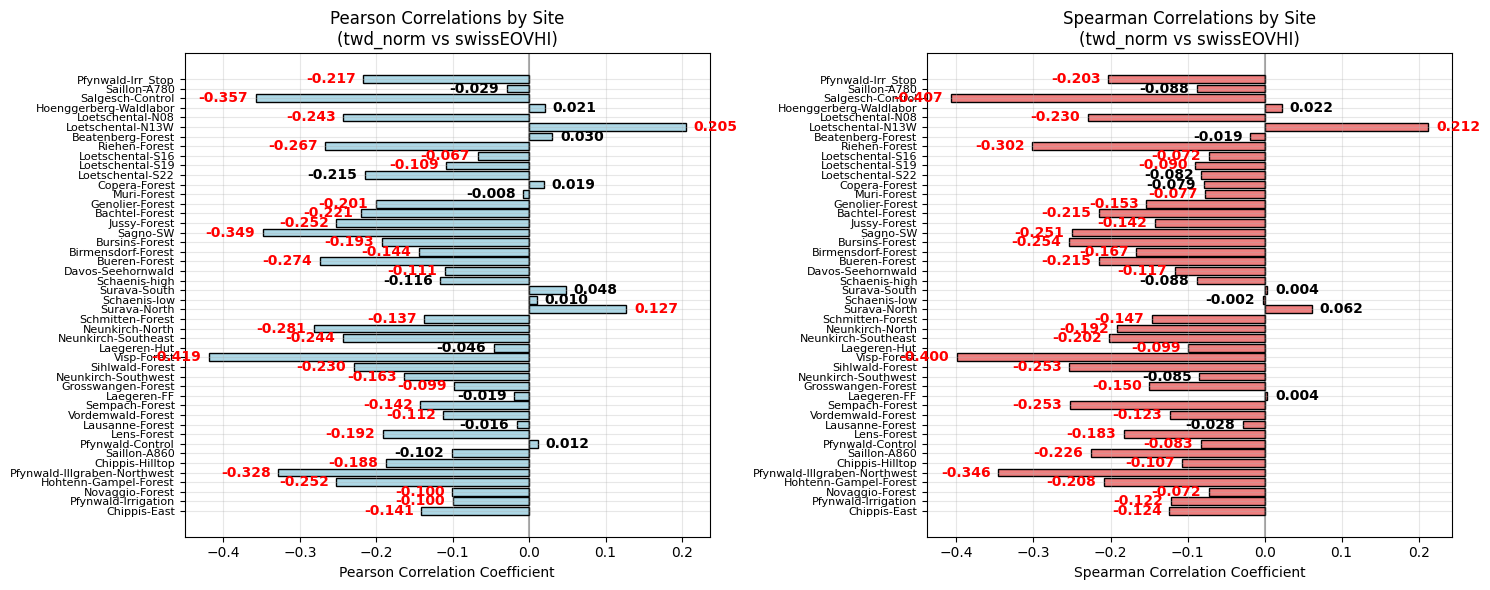


Note: Red text indicates statistically significant correlations (p < 0.05)


In [12]:
print("="*60)
print("SITE-SPECIFIC ANALYSIS")
print("="*60)

# Analyze correlations by site
site_correlations = []
min_observations = 10  # Minimum observations per site for reliable correlation

for site in df_clean['site_name'].unique():
    site_data = df_clean[df_clean['site_name'] == site]
    n_obs = len(site_data)

    if n_obs >= min_observations:
        site_pearson, site_p_pearson = pearsonr(site_data['twd_norm'], site_data['swissEOVHI'])
        site_spearman, site_p_spearman = spearmanr(site_data['twd_norm'], site_data['swissEOVHI'])

        site_correlations.append({
            'Site': site,
            'N_Observations': n_obs,
            'Pearson_r': site_pearson,
            'Pearson_p': site_p_pearson,
            'Spearman_r': site_spearman,
            'Spearman_p': site_p_spearman,
            'Mean_VHI': site_data['swissEOVHI'].mean(),
            'Std_VHI': site_data['swissEOVHI'].std(),
            'Mean_TWD': site_data['twd_norm'].mean(),
            'Std_TWD': site_data['twd_norm'].std()
        })

if site_correlations:
    site_df = pd.DataFrame(site_correlations)
    site_df = site_df.round(4)
    print(f"Site-specific correlations (sites with ≥{min_observations} observations):")
    display(site_df)

    # Plot site-specific correlations
    if len(site_df) > 1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Pearson correlations by site
        ax1.barh(range(len(site_df)), site_df['Pearson_r'], color='lightblue', edgecolor='black')
        ax1.set_yticks(range(len(site_df)))
        ax1.set_yticklabels(site_df['Site'], fontsize=8)
        ax1.set_xlabel('Pearson Correlation Coefficient')
        ax1.set_title('Pearson Correlations by Site\n(twd_norm vs swissEOVHI)')
        ax1.axvline(0, color='black', linestyle='-', alpha=0.3)
        ax1.grid(True, alpha=0.3)

        # Add correlation values as text
        for i, (r, p) in enumerate(zip(site_df['Pearson_r'], site_df['Pearson_p'])):
            color = 'red' if p < 0.05 else 'black'
            ax1.text(r + 0.01 if r >= 0 else r - 0.01, i, f'{r:.3f}',
                    va='center', ha='left' if r >= 0 else 'right', color=color, fontweight='bold')

        # Spearman correlations by site
        ax2.barh(range(len(site_df)), site_df['Spearman_r'], color='lightcoral', edgecolor='black')
        ax2.set_yticks(range(len(site_df)))
        ax2.set_yticklabels(site_df['Site'], fontsize=8)
        ax2.set_xlabel('Spearman Correlation Coefficient')
        ax2.set_title('Spearman Correlations by Site\n(twd_norm vs swissEOVHI)')
        ax2.axvline(0, color='black', linestyle='-', alpha=0.3)
        ax2.grid(True, alpha=0.3)

        # Add correlation values as text
        for i, (r, p) in enumerate(zip(site_df['Spearman_r'], site_df['Spearman_p'])):
            color = 'red' if p < 0.05 else 'black'
            ax2.text(r + 0.01 if r >= 0 else r - 0.01, i, f'{r:.3f}',
                    va='center', ha='left' if r >= 0 else 'right', color=color, fontweight='bold')

        plt.tight_layout()
        plt.show()

        print("\nNote: Red text indicates statistically significant correlations (p < 0.05)")

else:
    print(f"No sites have ≥{min_observations} observations for reliable correlation analysis")


 ## 9. Summary and Conclusions

In [13]:
print("="*80)
print("SUMMARY AND CONCLUSIONS")
print("="*80)

print(f"Dataset Summary:")
print(f"├─ Original dataset: {len(df):,} rows")
print(f"├─ DOY filtered ({DOY_start}-{DOY_end}): {total_filtered_rows:,} rows ({(total_filtered_rows/len(df))*100:.1f}%)")
print(f"├─ Valid data (swissEOMASK=0 & swissEOVHI≤100): {len(df_valid):,} rows ({(len(df_valid)/total_filtered_rows)*100:.1f}%)")
print(f"└─ Final analysis dataset: {len(df_clean):,} rows ({(len(df_clean)/len(df))*100:.1f}% of original)")

print(f"\nGrowing Season Focus (DOY {DOY_start}-{DOY_end}):")
# print(f"├─ April 1 to September 30")
# print(f"├─ Captures peak vegetation activity period")
# print(f"└─ Excludes winter dormancy and early spring/late fall periods")

print(f"\nVariable Characteristics:")
print(f"├─ twd_norm: Continuous values from {df_clean['twd_norm'].min():.3f} to {df_clean['twd_norm'].max():.3f}")
print(f"│  └─ Mean: {df_clean['twd_norm'].mean():.3f} ± {df_clean['twd_norm'].std():.3f}")
print(f"└─ swissEOVHI: Values from {df_clean['swissEOVHI'].min():.1f} to {df_clean['swissEOVHI'].max():.1f}")
print(f"   └─ Mean: {df_clean['swissEOVHI'].mean():.1f} ± {df_clean['swissEOVHI'].std():.1f}")

print(f"\nCorrelation Results:")
print(f"├─ Pearson correlation: {pearson_corr:.4f} ({interpret_correlation(pearson_corr)})")
print(f"│  └─ Significance: {'✓ Significant' if pearson_p < 0.05 else '✗ Not significant'} (p = {pearson_p:.4f})")
print(f"└─ Spearman correlation: {spearman_corr:.4f} ({interpret_correlation(spearman_corr)})")
print(f"   └─ Significance: {'✓ Significant' if spearman_p < 0.05 else '✗ Not significant'} (p = {spearman_p:.4f})")

print(f"\nRecommendations:")
print(f"├─ Use Pearson correlation for continuous twd_norm values (-2 to -10)")
if abs(pearson_corr) > abs(spearman_corr):
    print(f"├─ Pearson correlation is stronger, suggesting linear relationship")
else:
    print(f"├─ Spearman correlation is stronger, suggesting non-linear relationship")

if len(site_correlations) > 0:
    significant_sites = sum(1 for site in site_correlations if site['Pearson_p'] < 0.05)
    print(f"└─ Site-specific analysis: {significant_sites}/{len(site_correlations)} sites show significant correlations")

print(f"\nBiological Interpretation:")
if pearson_corr > 0:
    print(f"├─ Positive correlation: Higher water deficit associated with higher vegetation health index")
    print(f"└─ This might seem counterintuitive - investigate potential confounding factors")
elif pearson_corr < 0:
    print(f"├─ Negative correlation: Higher water deficit associated with lower vegetation health index")
    print(f"└─ This aligns with expected biological relationship")
else:
    print(f"└─ No meaningful correlation detected between water deficit and vegetation health")

print(f"\nLinear Model:")
print(f"└─ swissEOVHI = {intercept:.2f} + {slope:.4f} × twd_norm (R² = {r_value**2:.4f})")


SUMMARY AND CONCLUSIONS
Dataset Summary:
├─ Original dataset: 347,299 rows
├─ DOY filtered (1-365): 347,299 rows (100.0%)
├─ Valid data (swissEOMASK=0 & swissEOVHI≤100): 25,016 rows (7.2%)
└─ Final analysis dataset: 25,016 rows (7.2% of original)

Growing Season Focus (DOY 1-365):

Variable Characteristics:
├─ twd_norm: Continuous values from 0.000 to 9.681
│  └─ Mean: 0.978 ± 1.100
└─ swissEOVHI: Values from 0.0 to 100.0
   └─ Mean: 52.4 ± 23.6

Correlation Results:
├─ Pearson correlation: -0.1277 (weak negative)
│  └─ Significance: ✓ Significant (p = 0.0000)
└─ Spearman correlation: -0.1323 (weak negative)
   └─ Significance: ✓ Significant (p = 0.0000)

Recommendations:
├─ Use Pearson correlation for continuous twd_norm values (-2 to -10)
├─ Spearman correlation is stronger, suggesting non-linear relationship
└─ Site-specific analysis: 32/46 sites show significant correlations

Biological Interpretation:
├─ Negative correlation: Higher water deficit associated with lower vegetation h

 ## 10. VHI vs twd_norm anomalies scatter plot with site annotations:

<Figure size 1200x800 with 0 Axes>

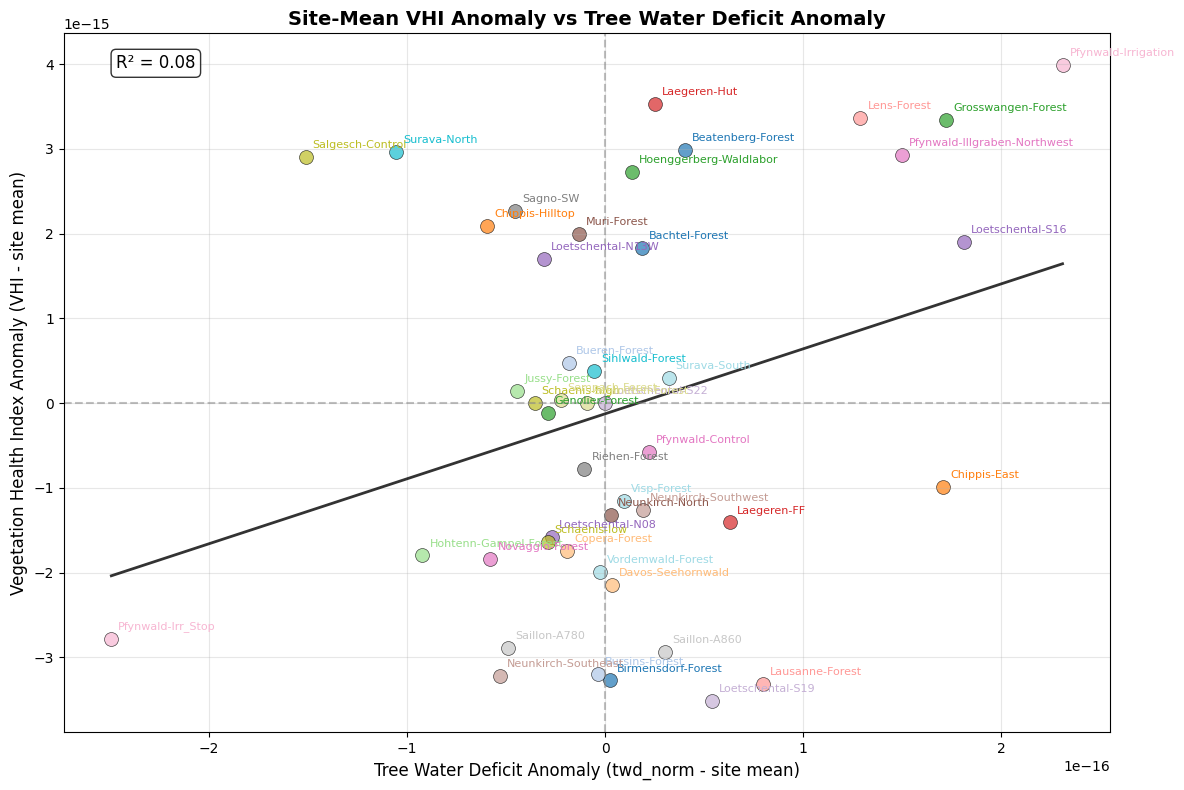

In [14]:
# Calculate TWD anomalies (deviation from site mean)
df_clean['twd_anomaly'] = df_clean.groupby('site_name')['twd_norm'].transform(lambda x: x - x.mean())

# Calculate VHI anomalies (deviation from site mean)
df_clean['vhi_anomaly'] = df_clean.groupby('site_name')['swissEOVHI'].transform(lambda x: x - x.mean())


# Create VHI vs TWD anomaly scatter plot with site annotations
plt.figure(figsize=(12, 8))

# Calculate site means for plotting (both anomalies should be ~0)
site_means_anom = df_clean.groupby('site_name').agg({
    'twd_anomaly': 'mean',
    'vhi_anomaly': 'mean'
}).reset_index()

# Colors wie zuvor
colors = plt.cm.tab20(np.linspace(0, 1, len(site_means_anom)))
site_colors = dict(zip(site_means_anom['site_name'], colors))

# Scatterplot mit VHI-Anomalie
plt.figure(figsize=(12, 8))
for i, row in site_means_anom.iterrows():
    plt.scatter(row['twd_anomaly'], row['vhi_anomaly'],
                color=site_colors[row['site_name']],
                s=100, alpha=0.7, edgecolor='black', linewidth=0.5)
    plt.annotate(row['site_name'],
                 (row['twd_anomaly'], row['vhi_anomaly']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8, ha='left', va='bottom',
                 color=site_colors[row['site_name']])

# Trendlinie
z = np.polyfit(site_means_anom['twd_anomaly'], site_means_anom['vhi_anomaly'], 1)
p = np.poly1d(z)
x_trend = np.linspace(site_means_anom['twd_anomaly'].min(), site_means_anom['twd_anomaly'].max(), 100)
plt.plot(x_trend, p(x_trend), "k-", alpha=0.8, linewidth=2)

# R²
site_r, _ = pearsonr(site_means_anom['twd_anomaly'], site_means_anom['vhi_anomaly'])
plt.text(0.05, 0.95, f'R² = {site_r**2:.2f}', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xlabel('Tree Water Deficit Anomaly (twd_norm - site mean)', fontsize=12)
plt.ylabel('Vegetation Health Index Anomaly (VHI - site mean)', fontsize=12)
plt.title('Site-Mean VHI Anomaly vs Tree Water Deficit Anomaly', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 11. Zeitreihenplots für jede Station (mit Subplots)

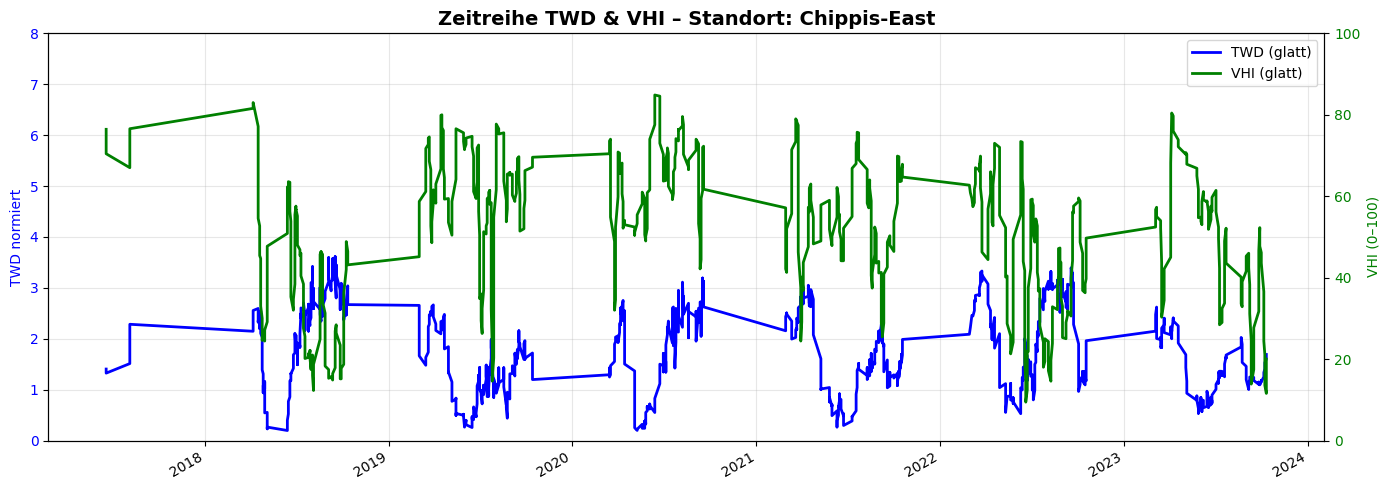

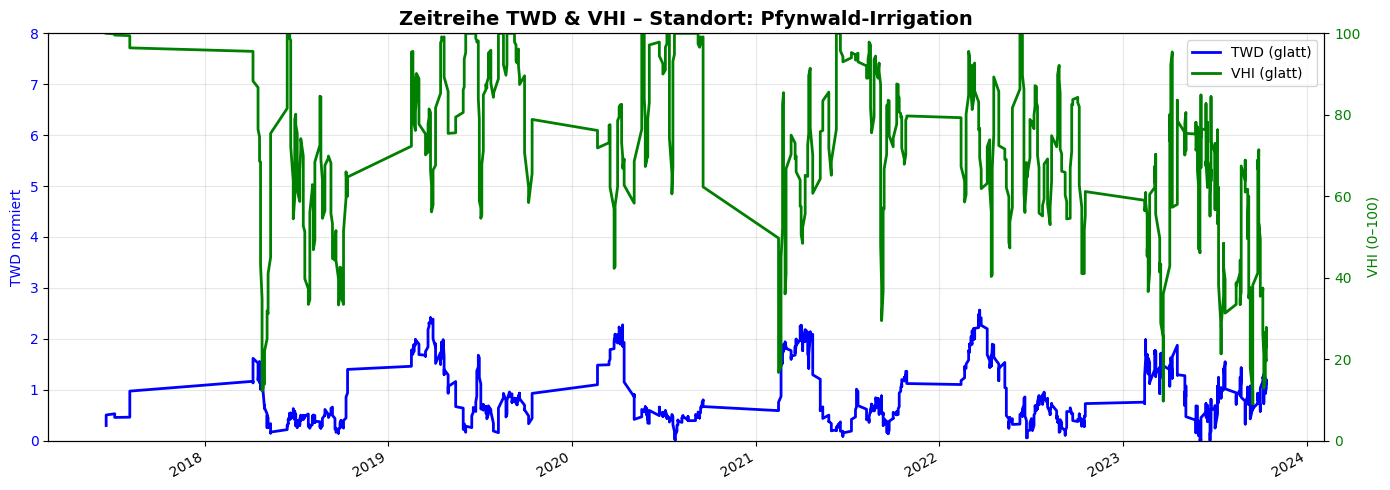

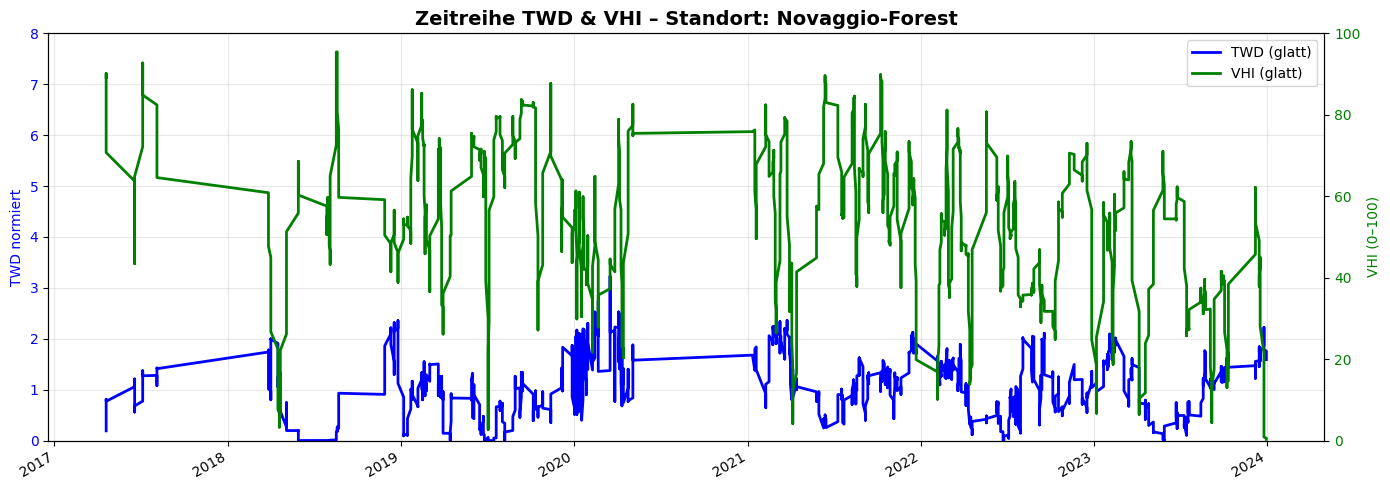

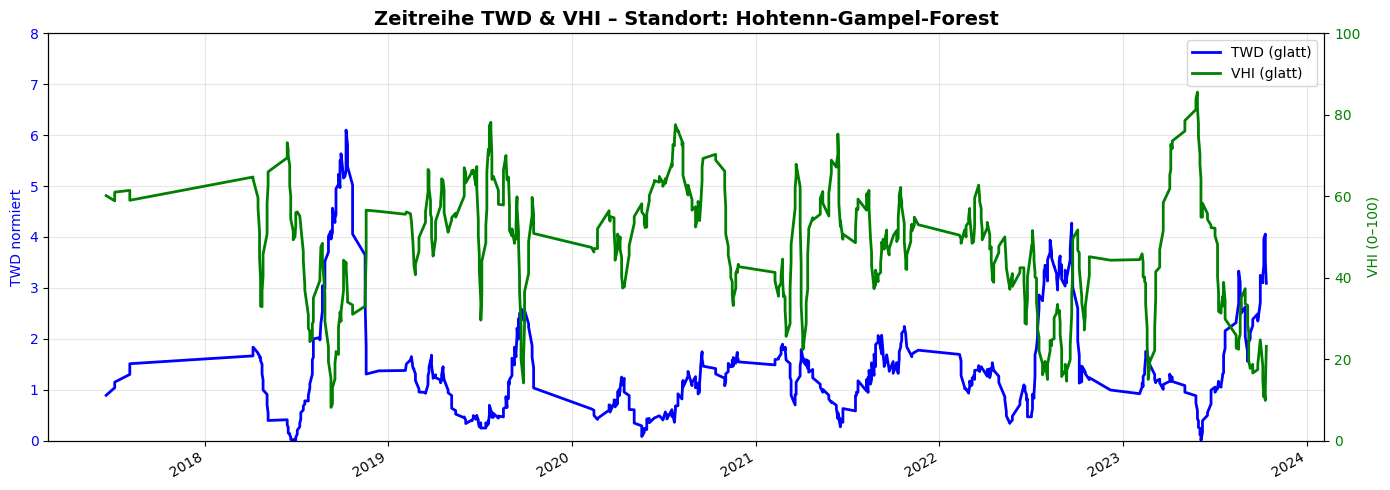

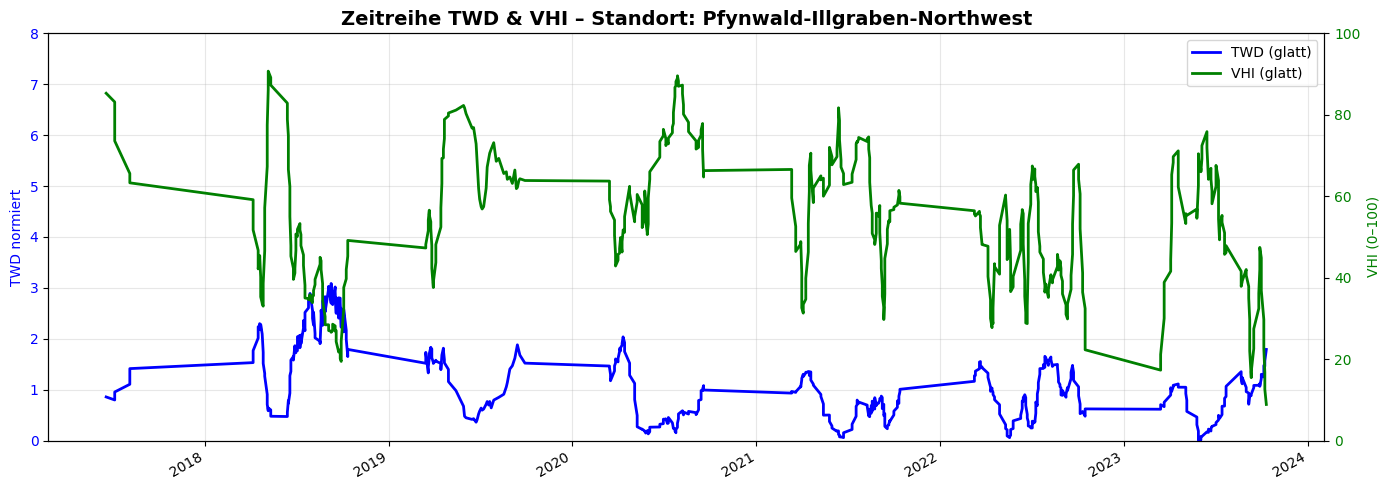

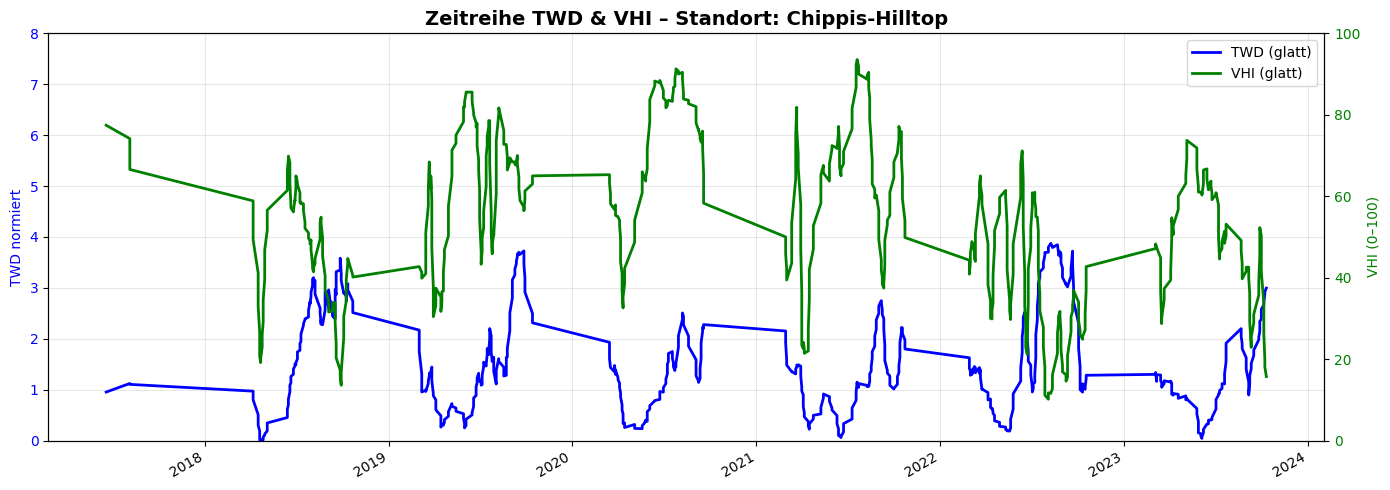

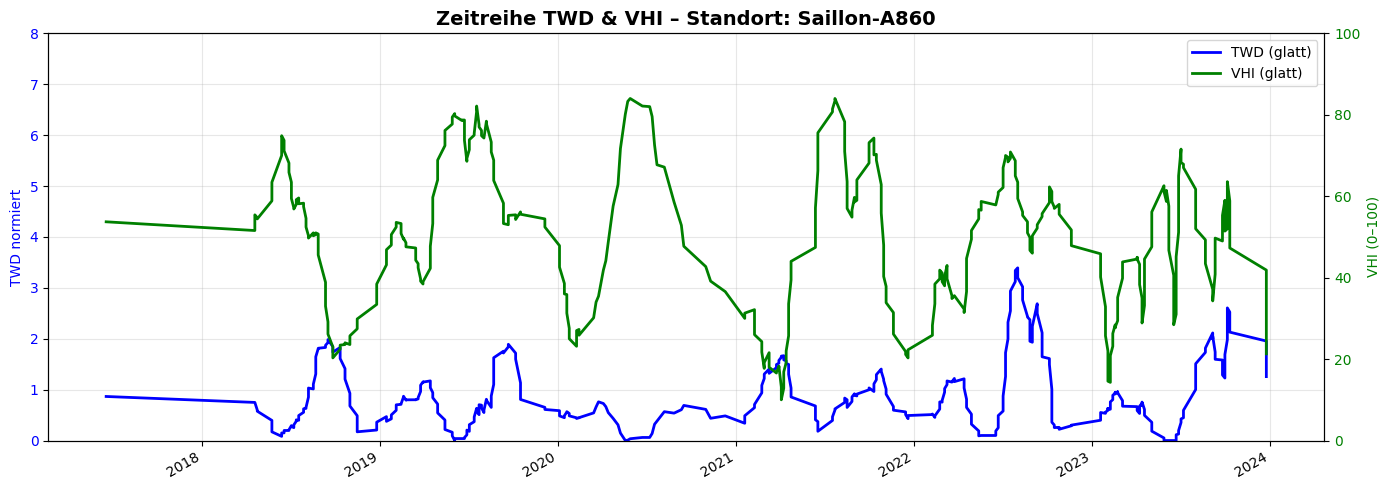

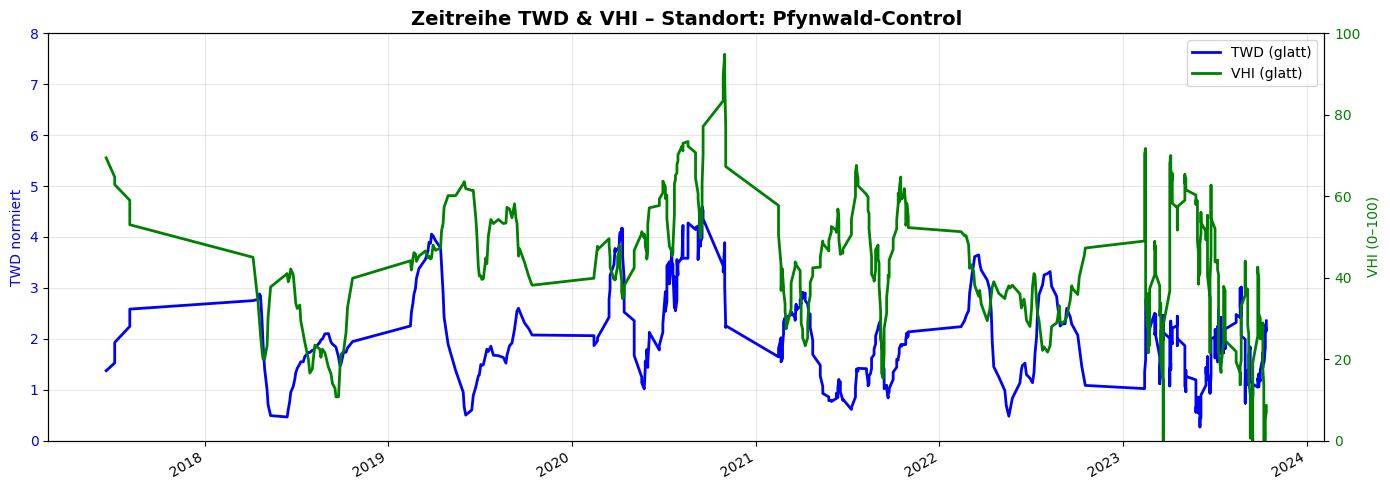

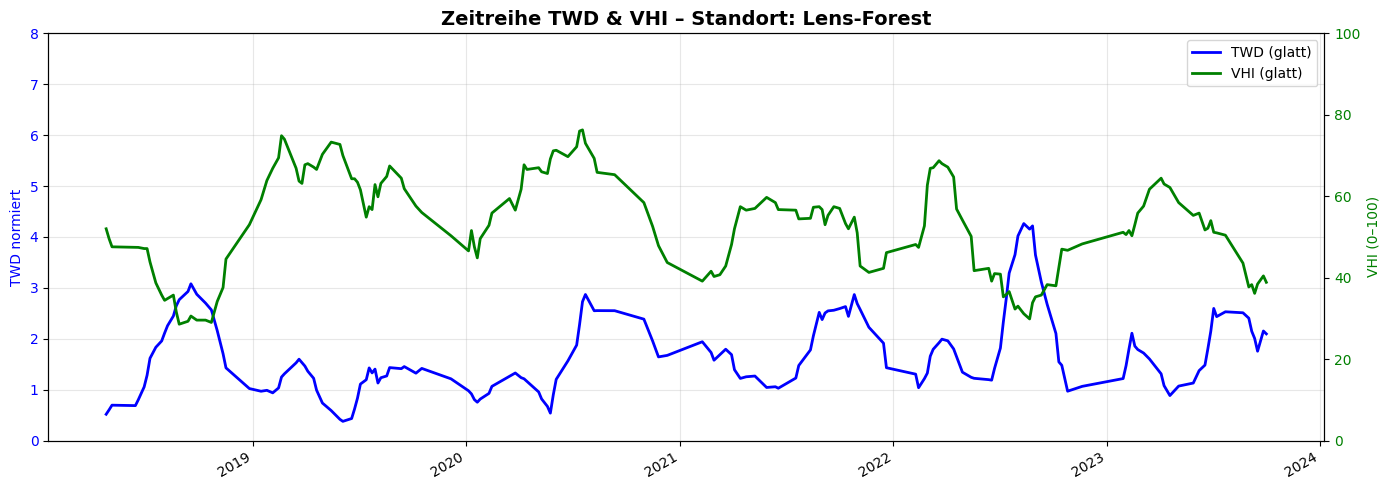

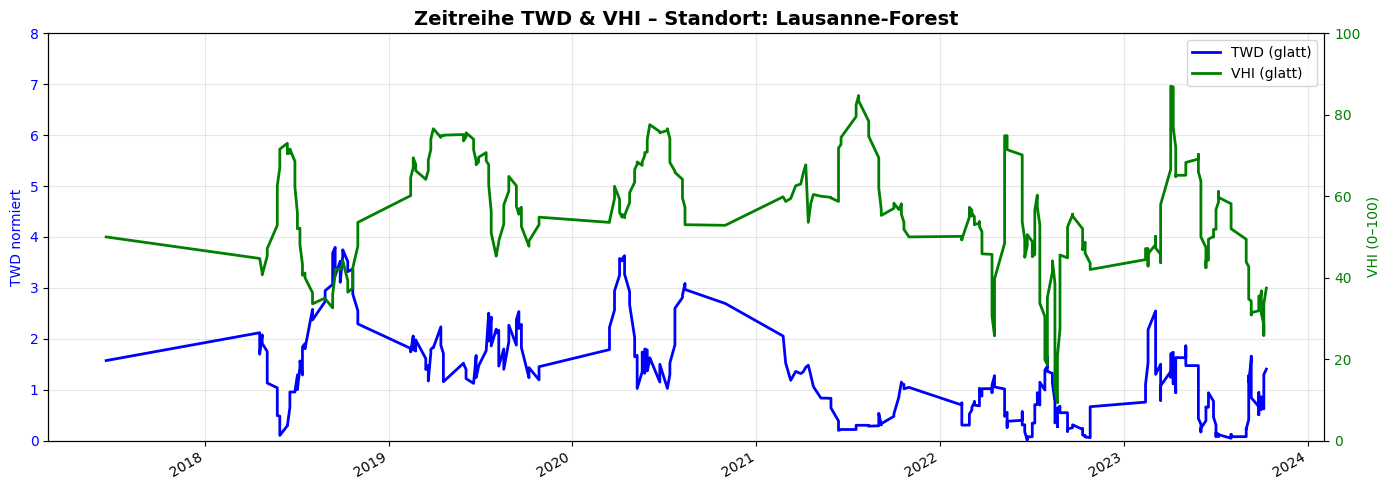

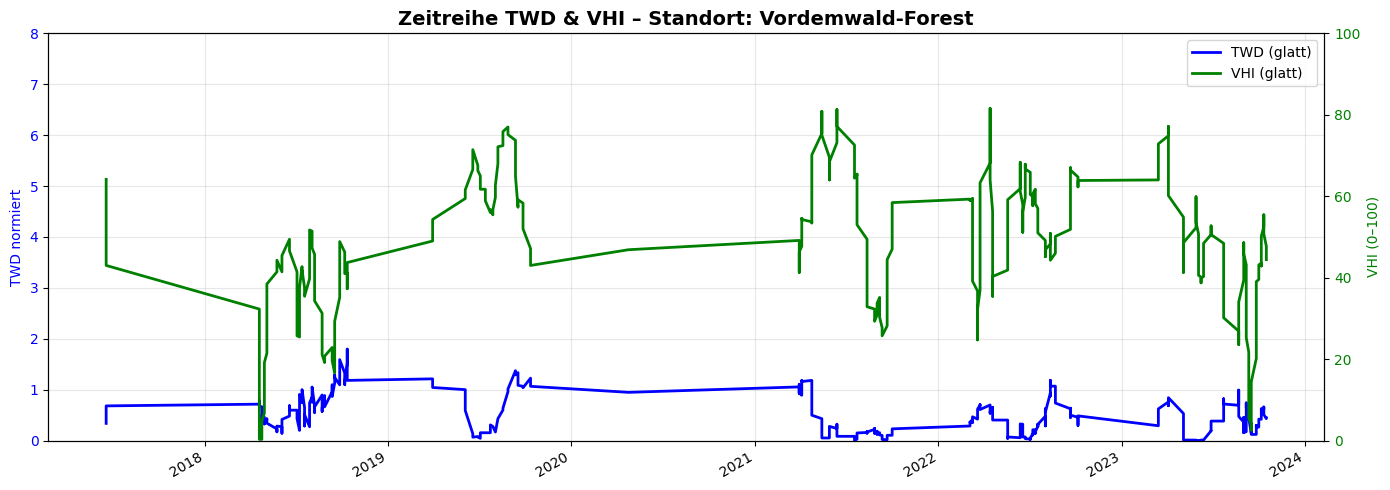

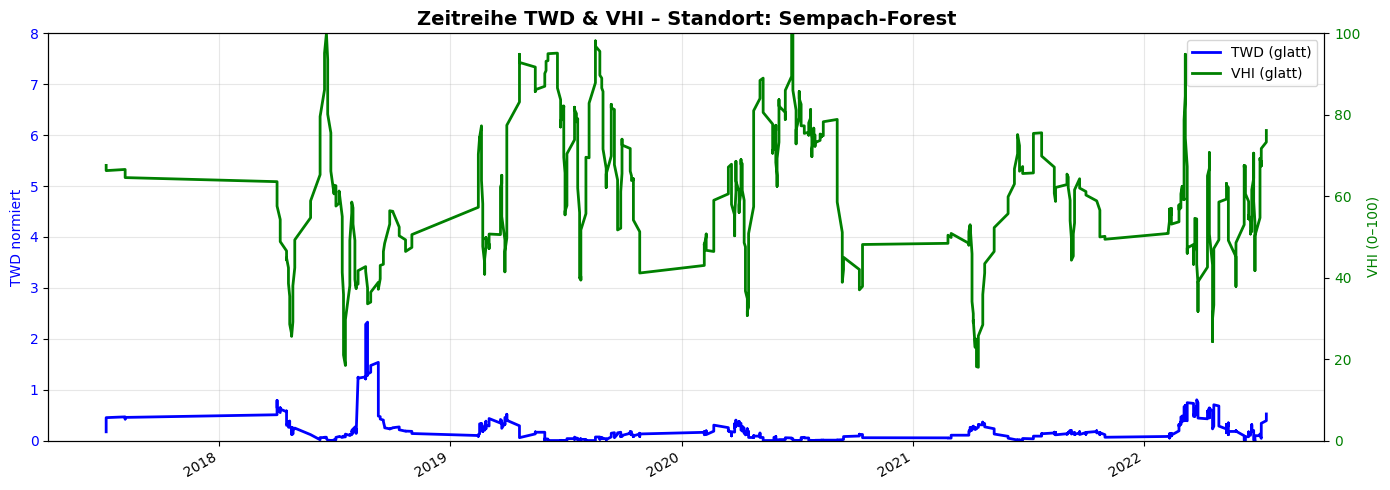

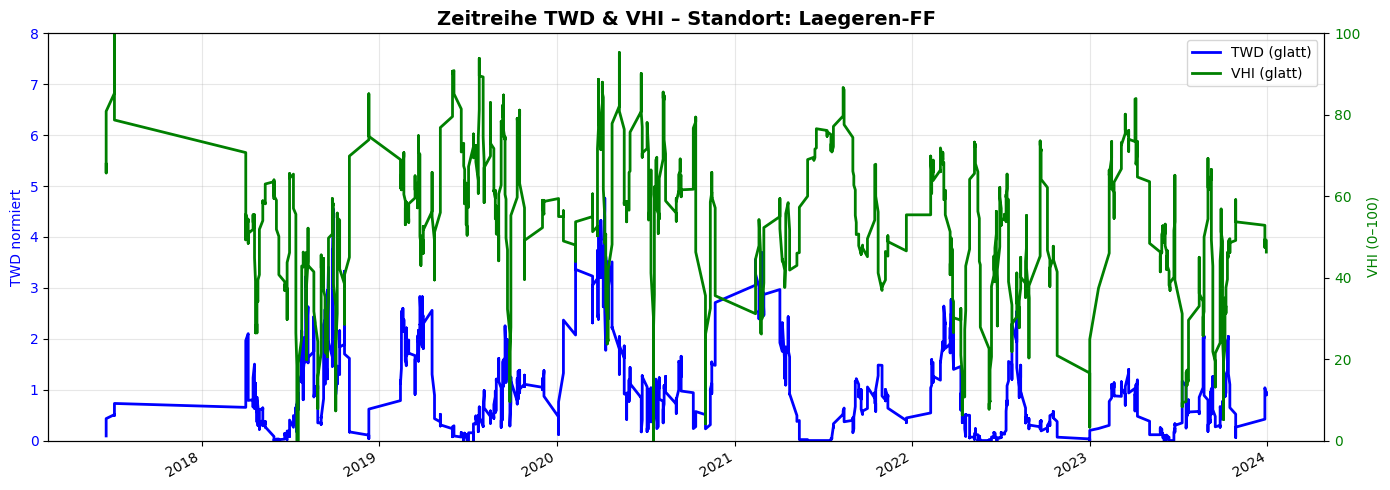

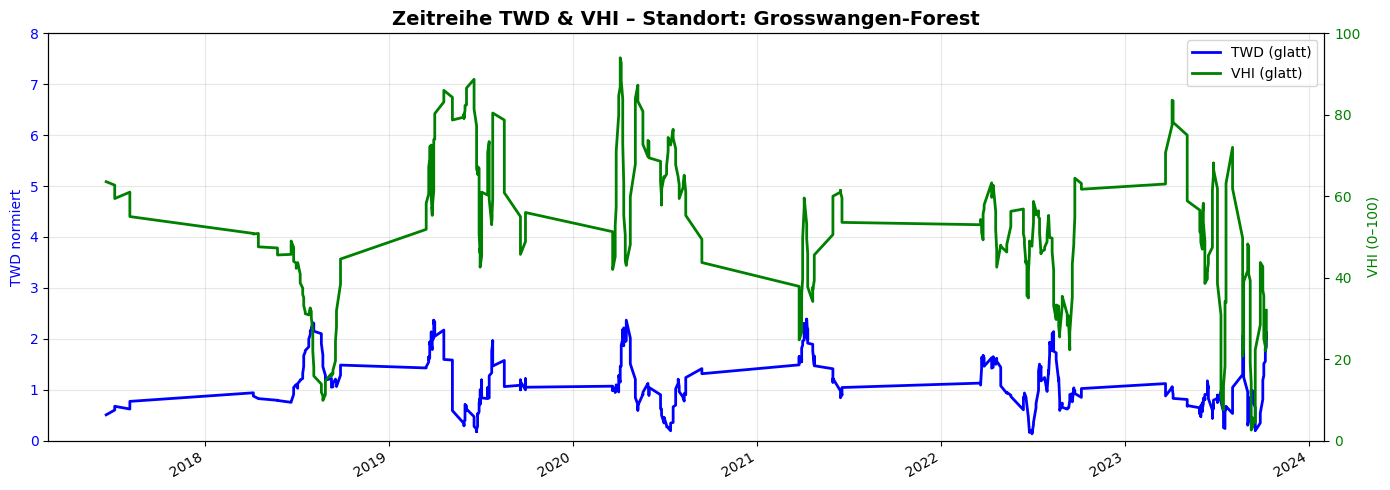

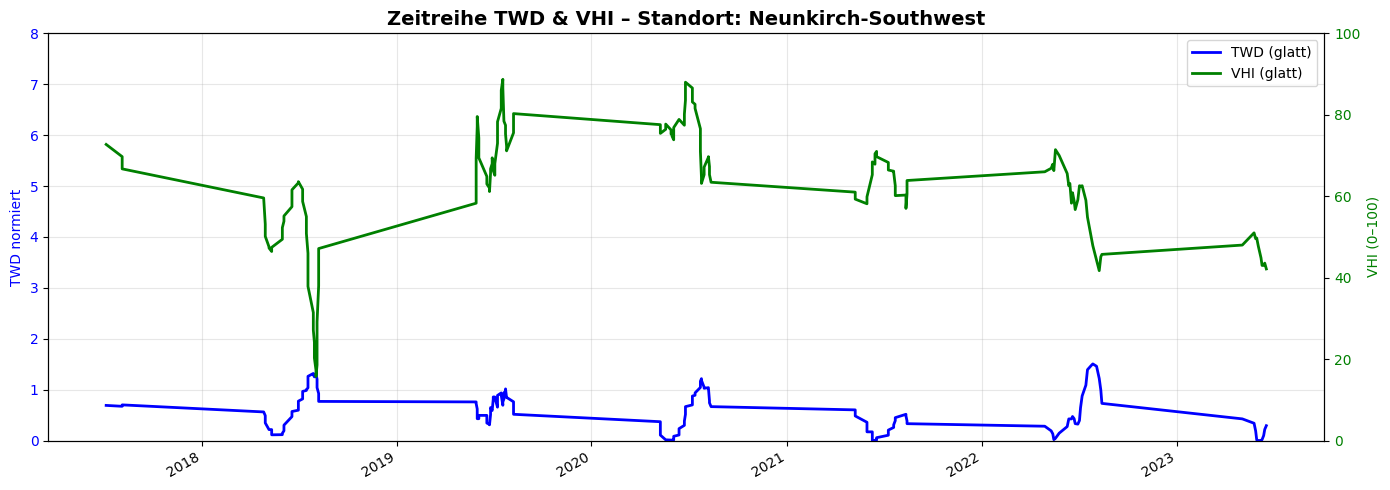

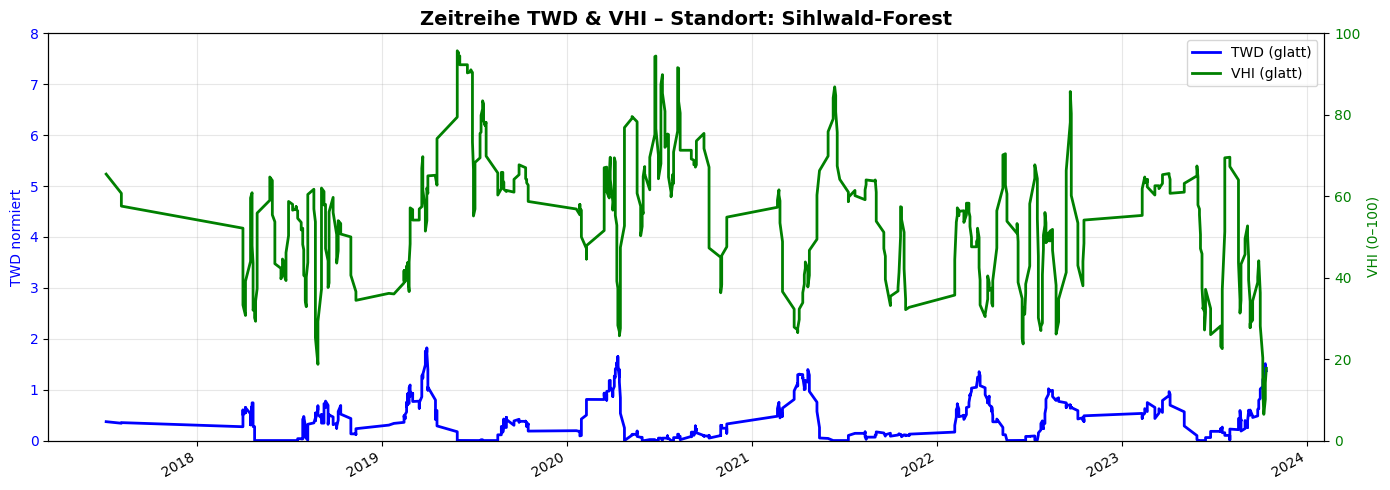

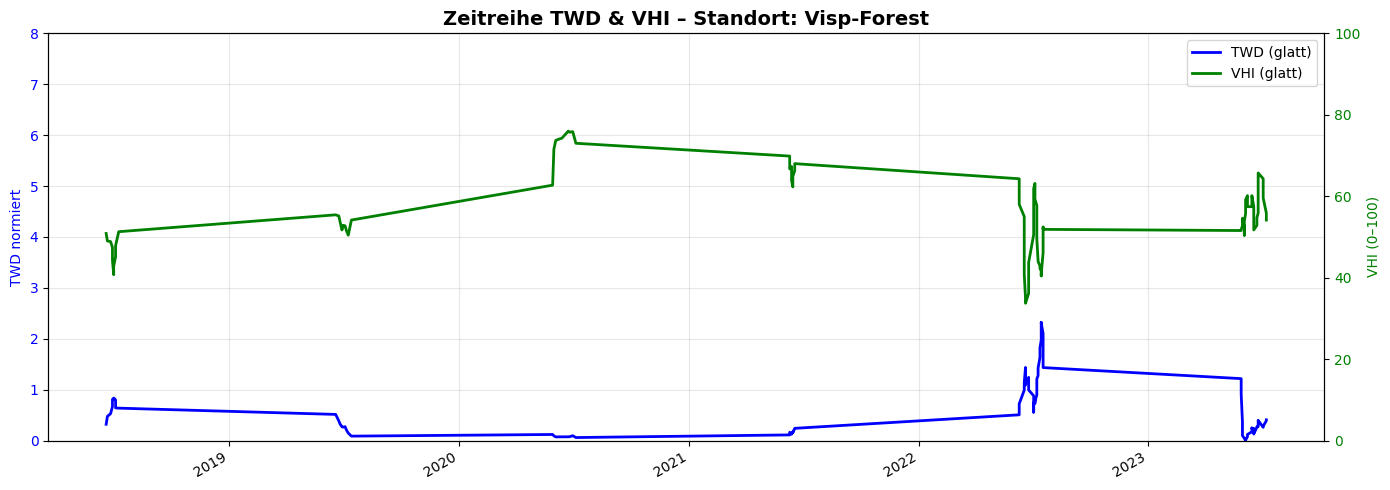

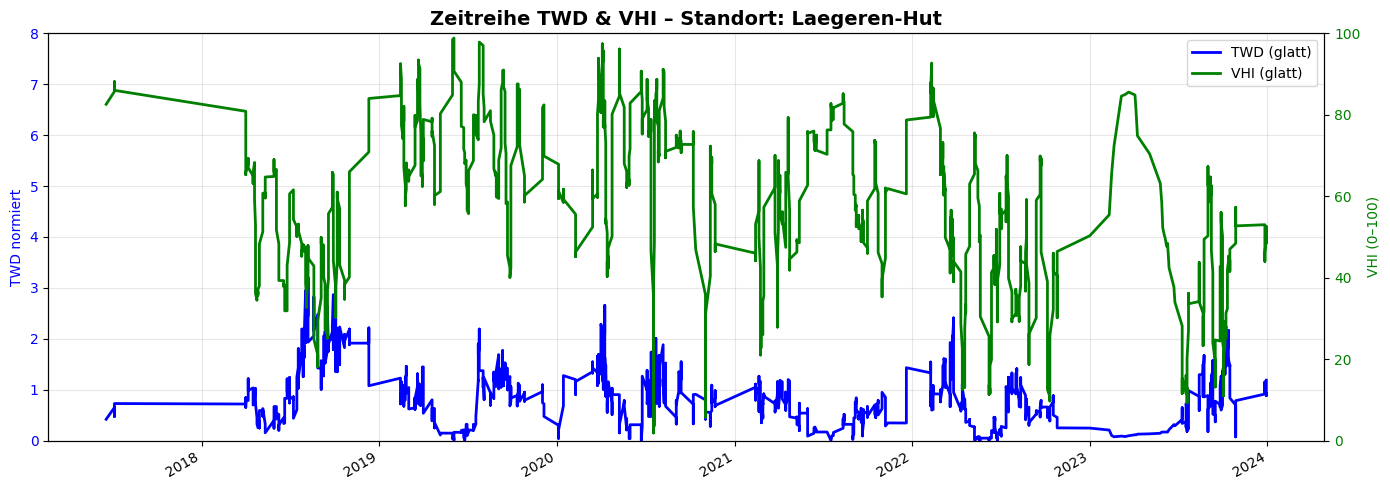

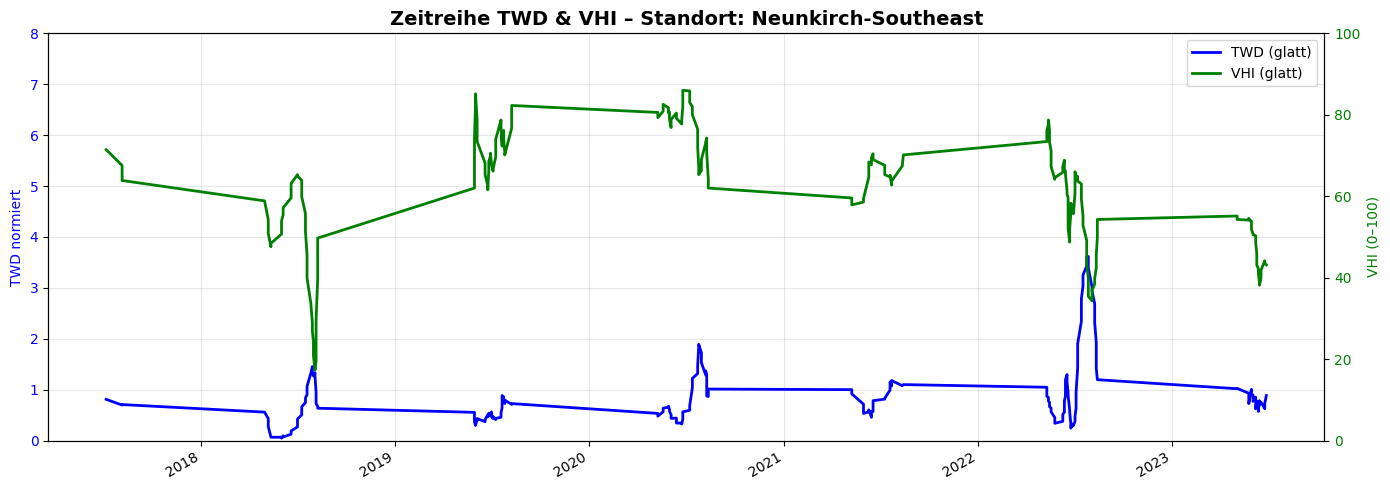

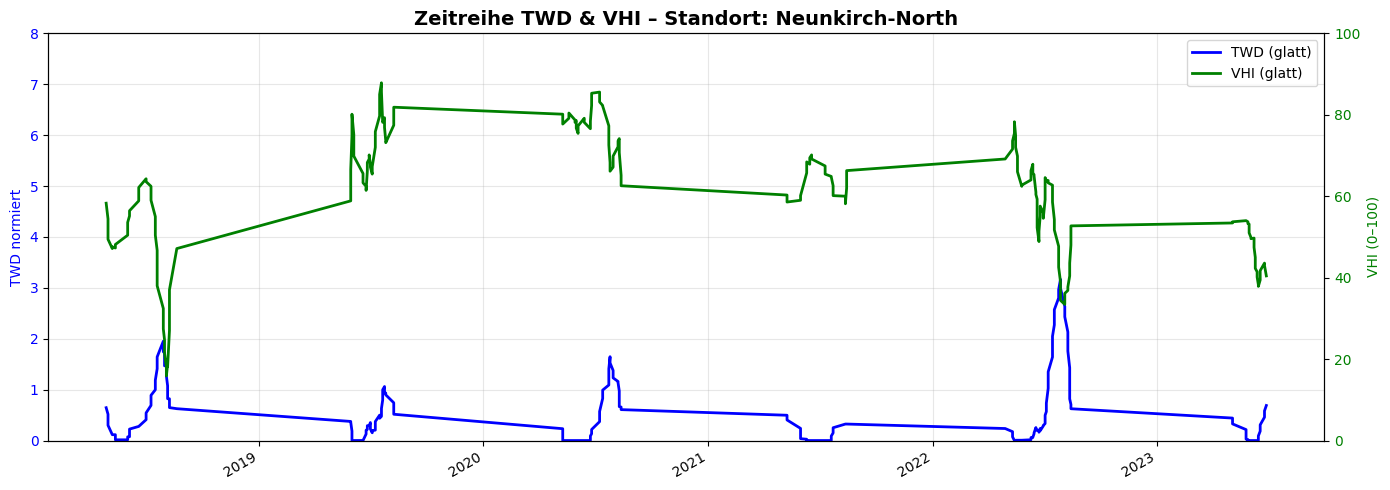

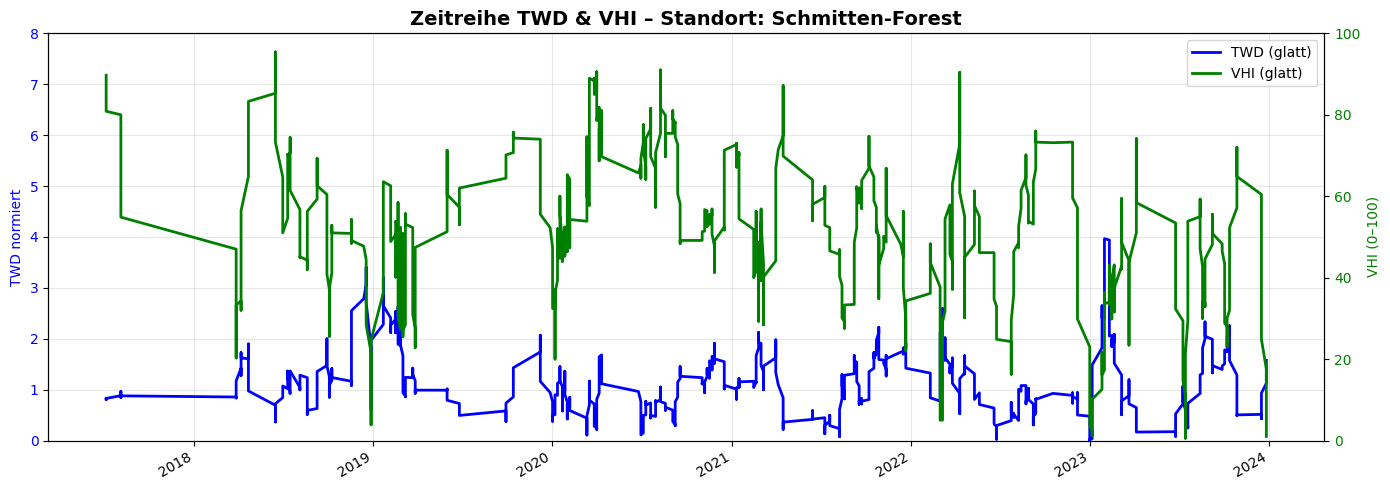

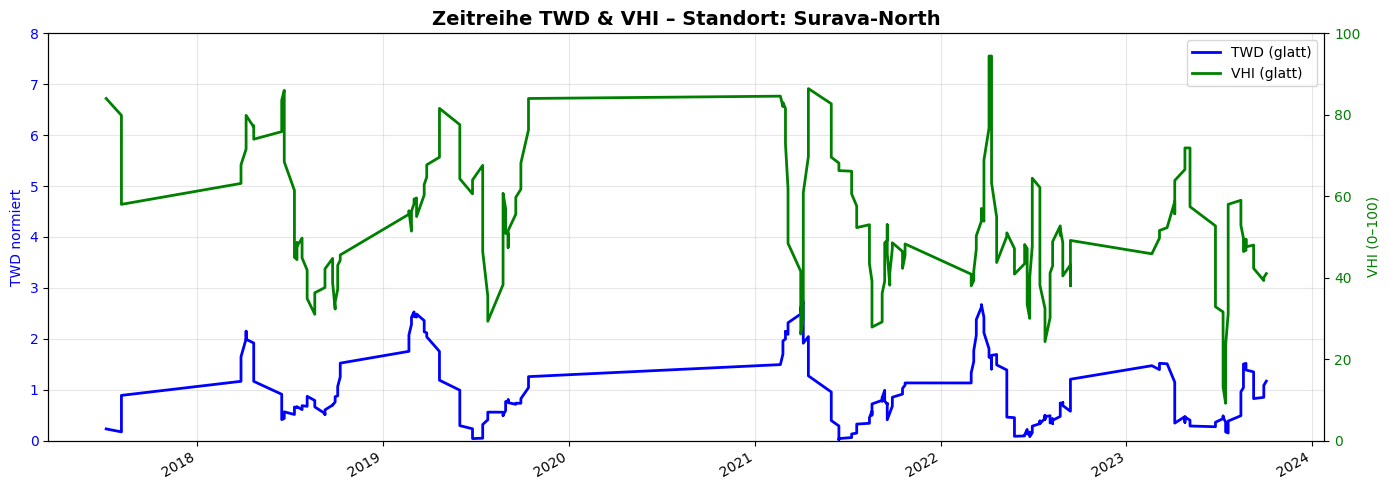

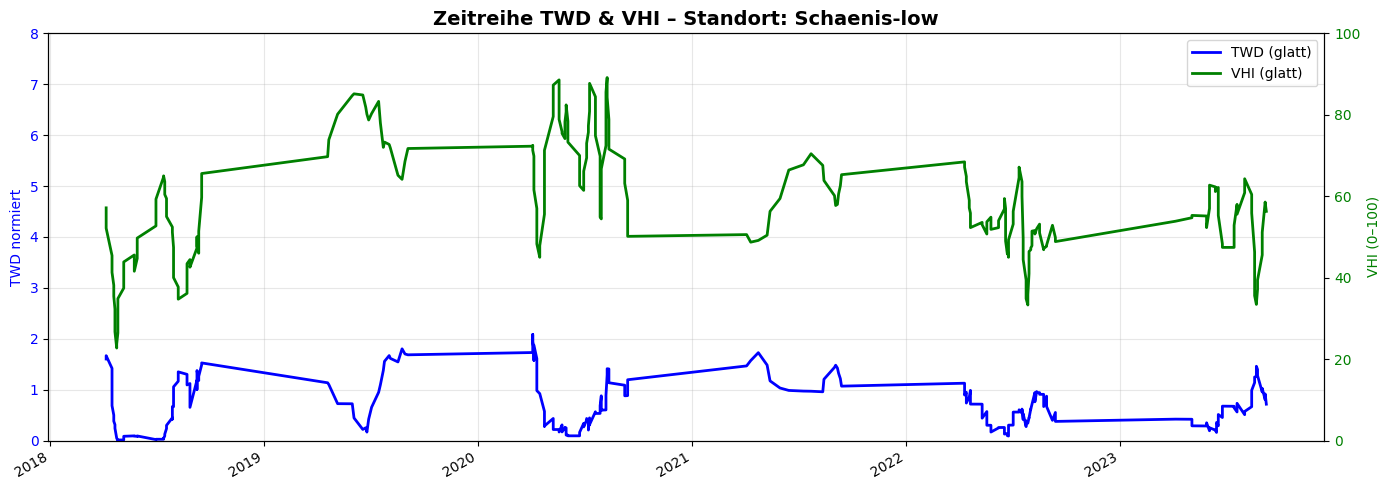

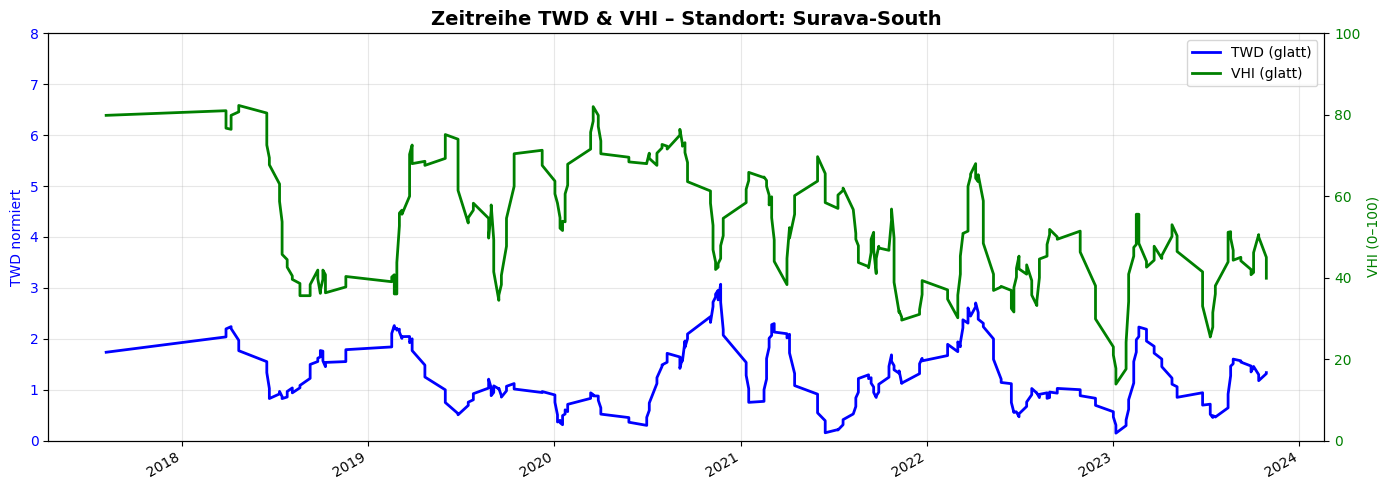

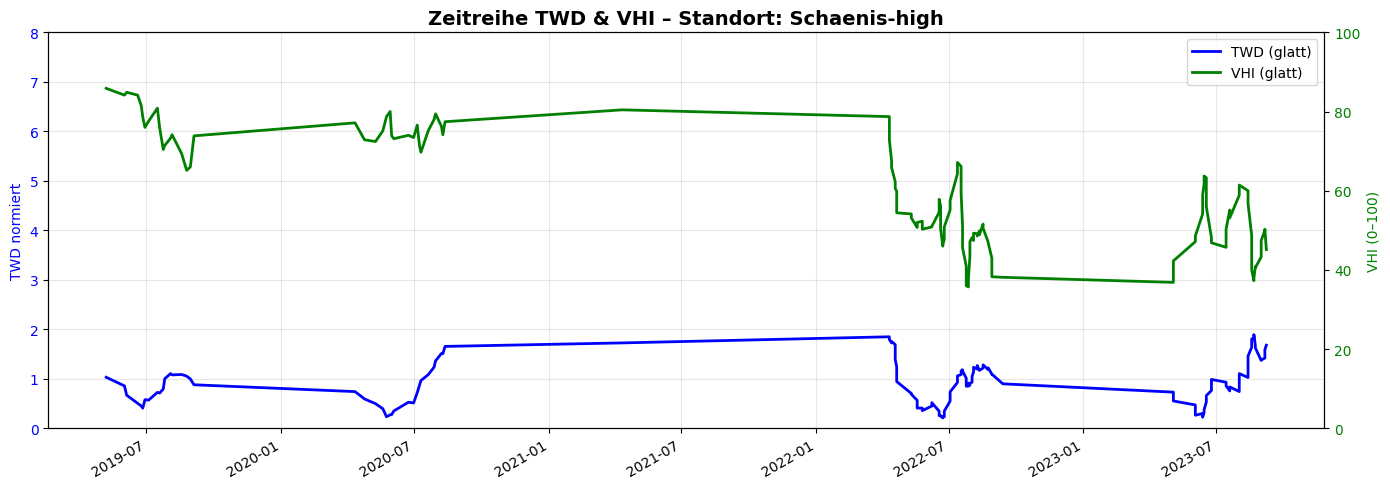

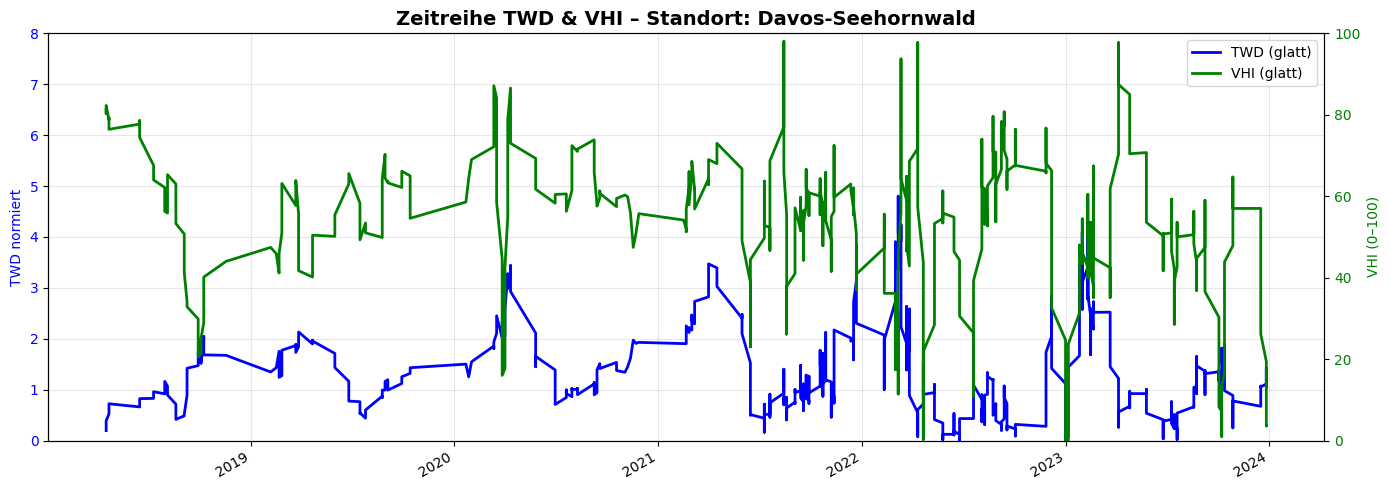

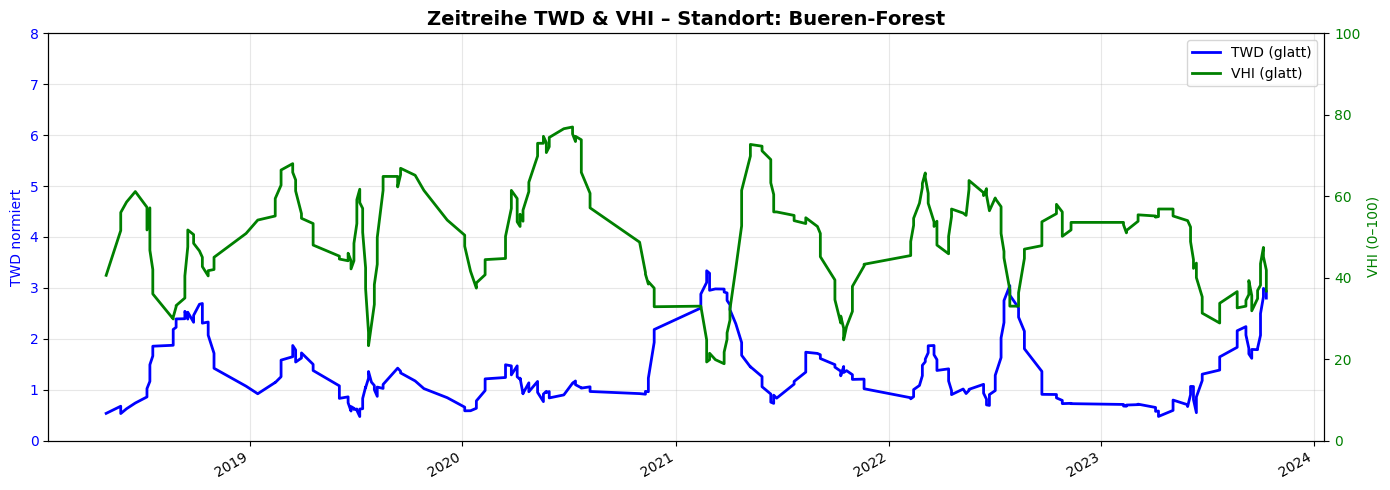

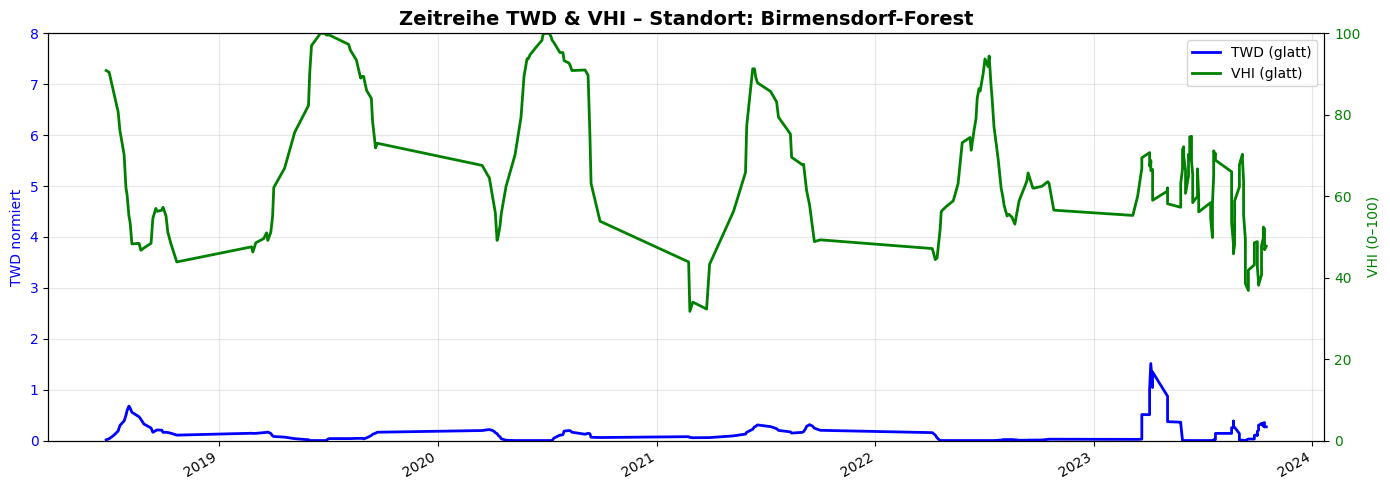

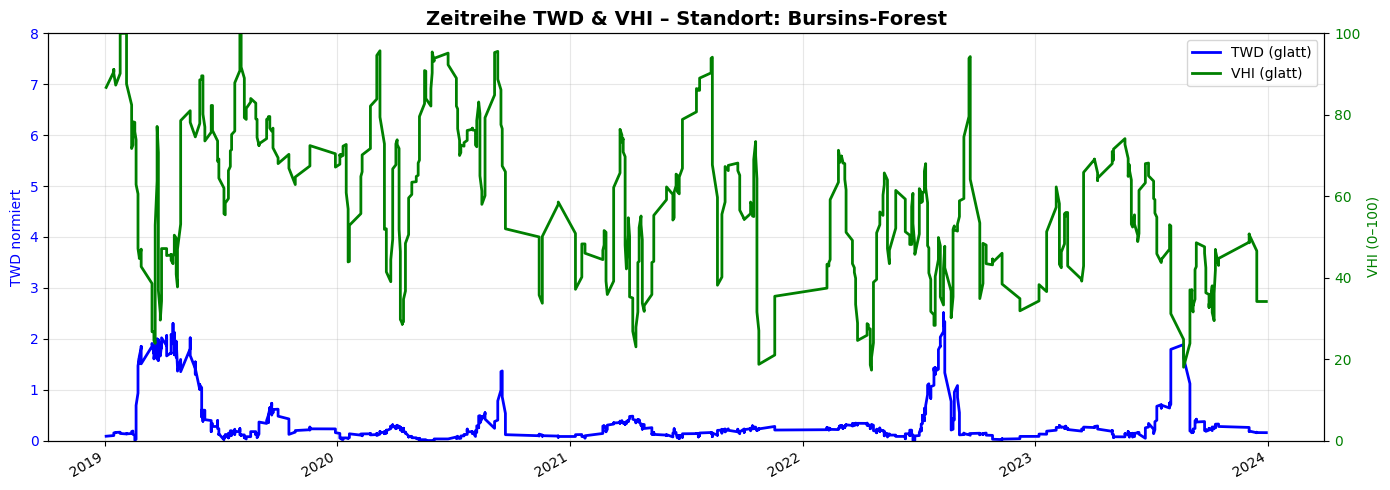

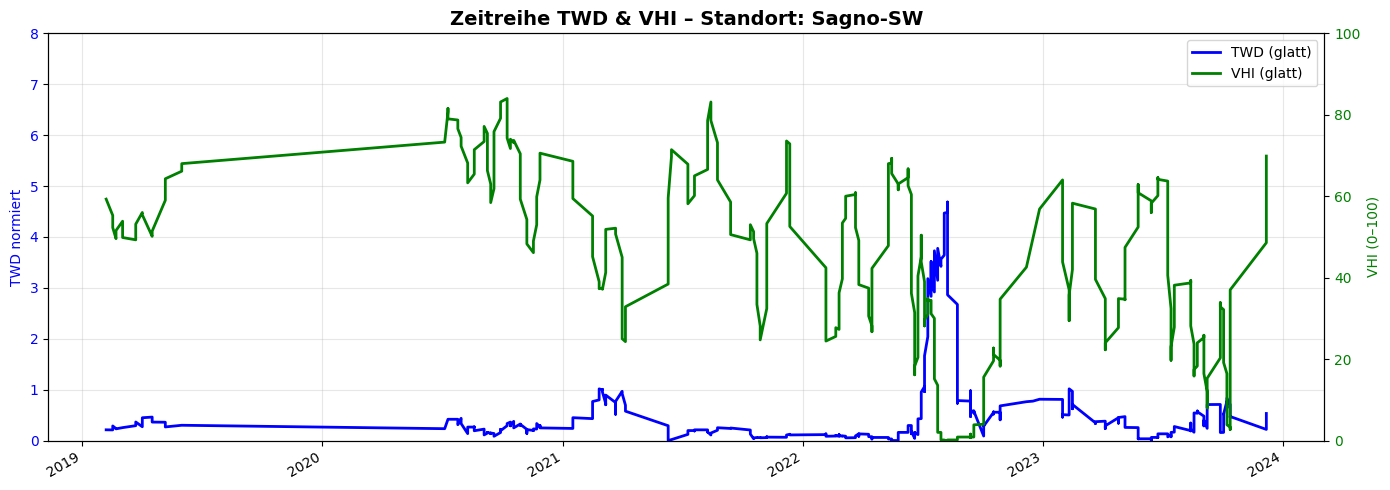

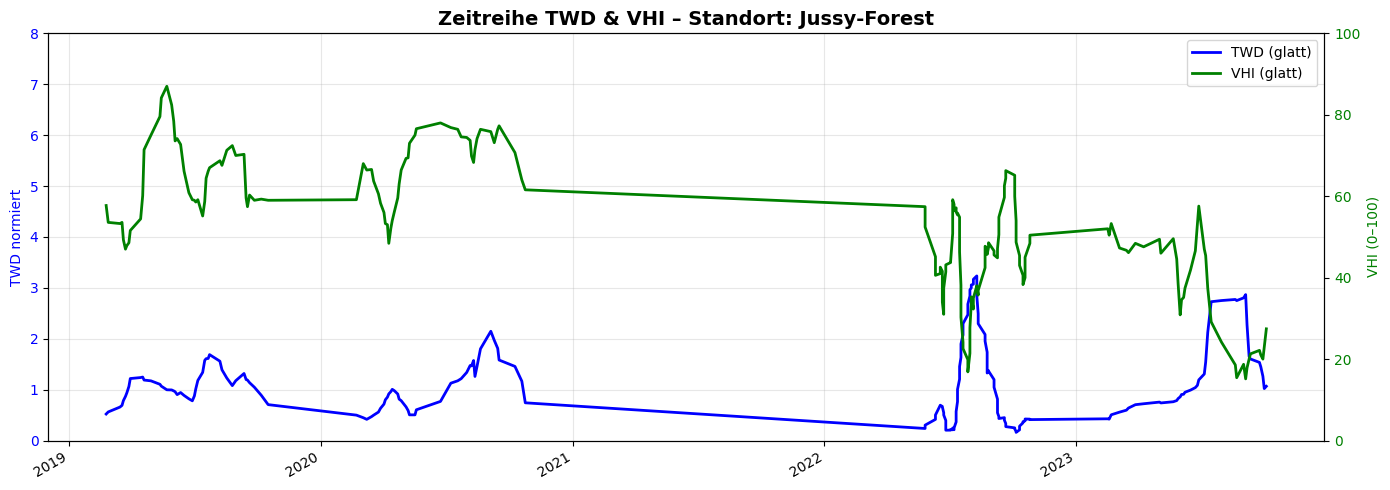

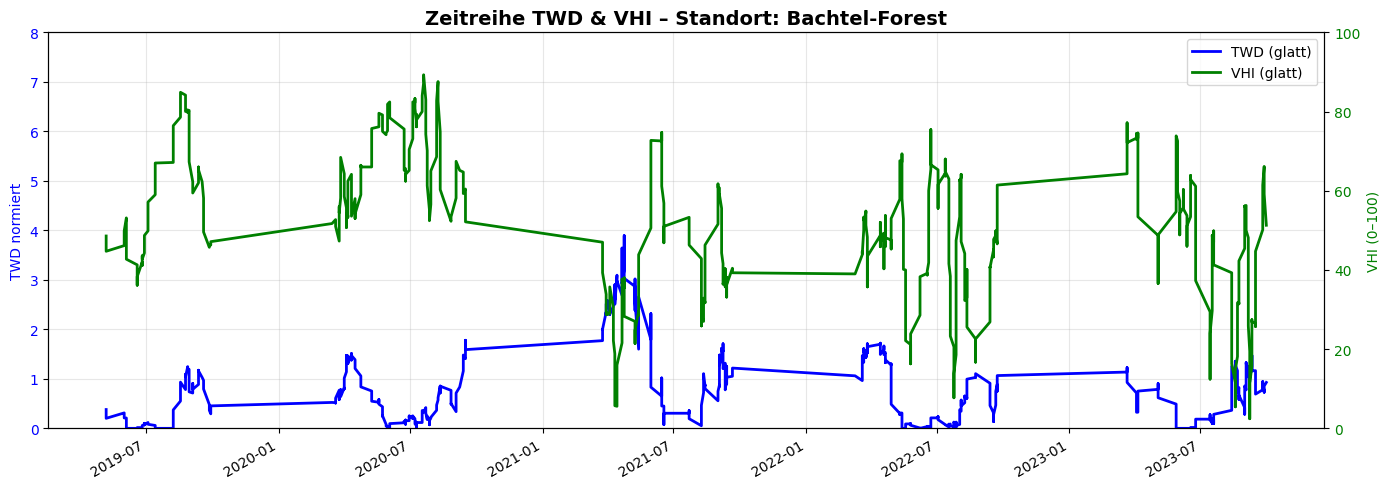

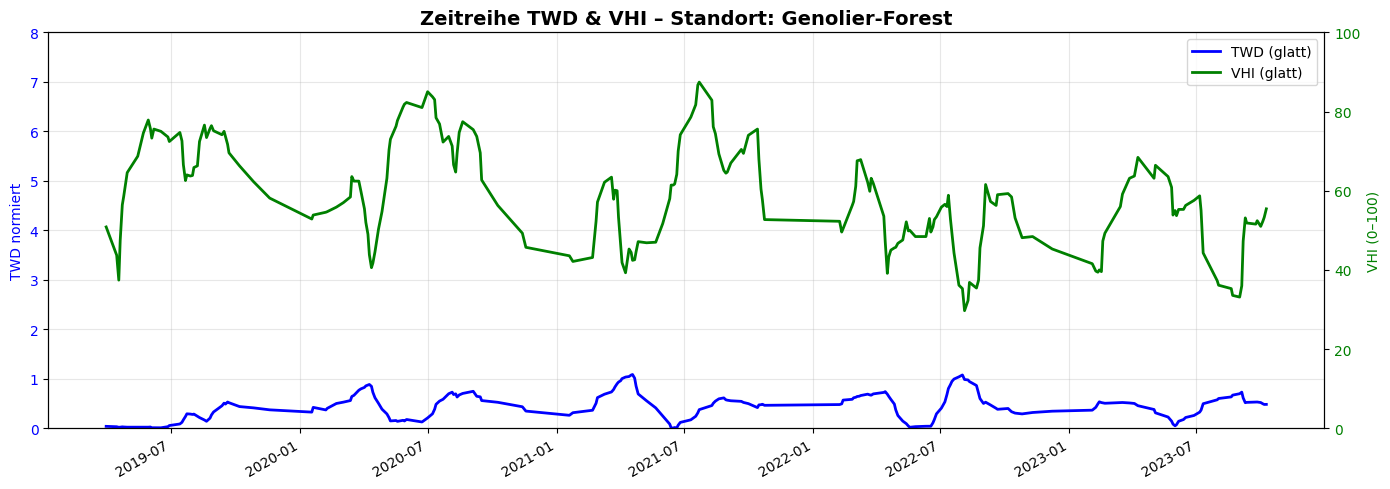

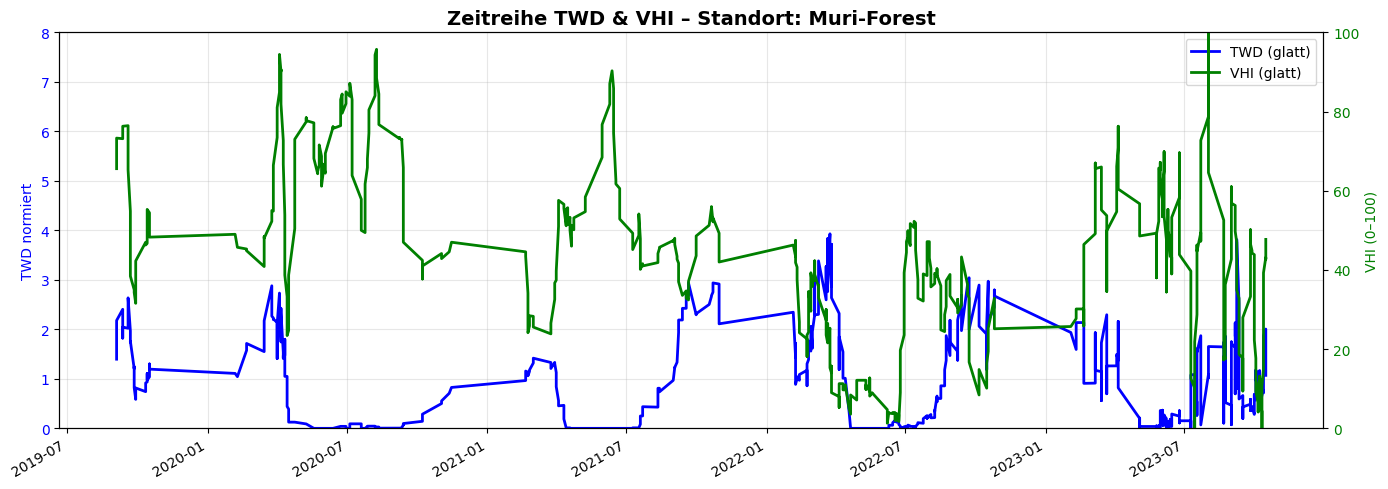

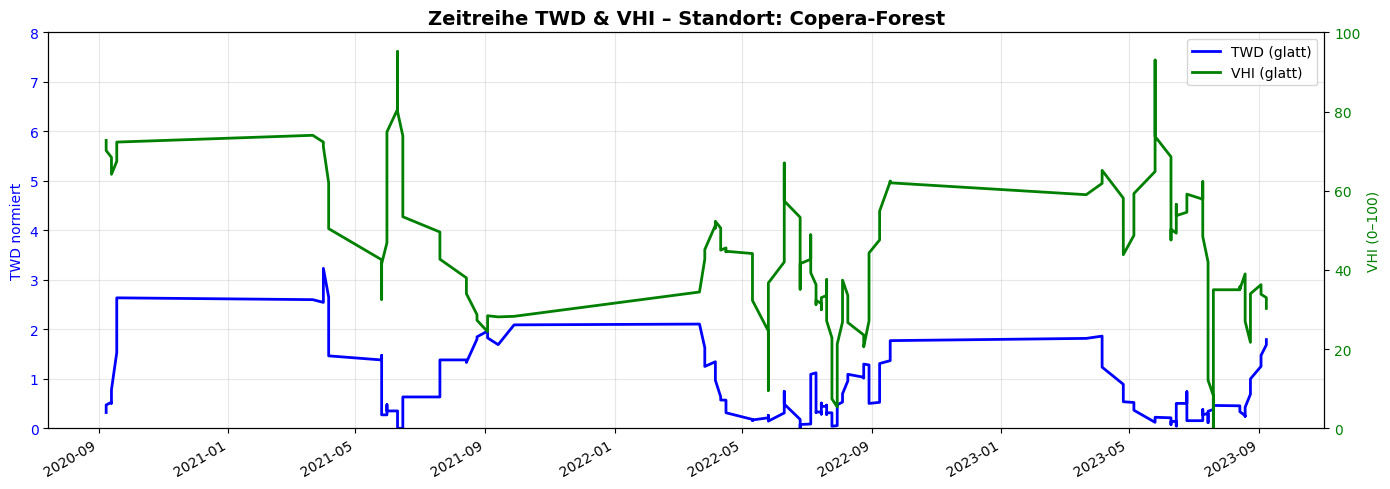

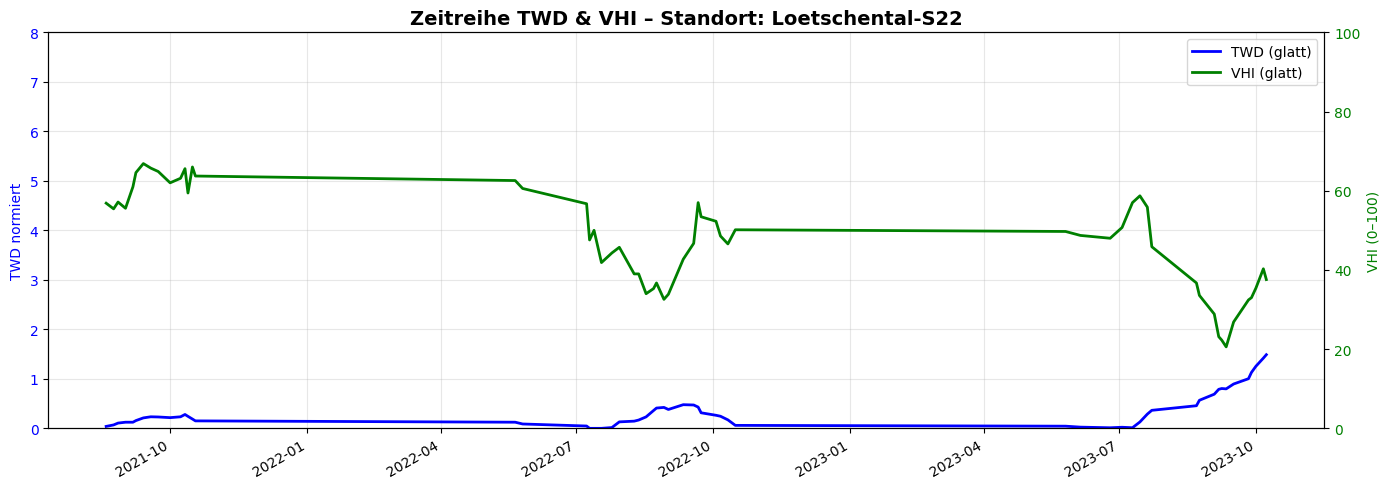

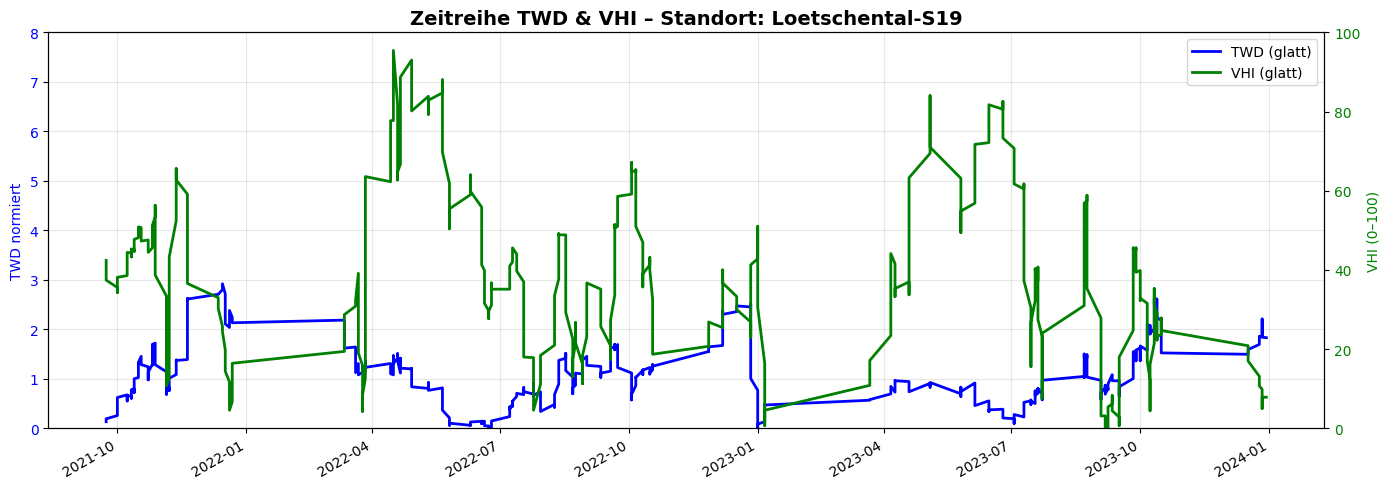

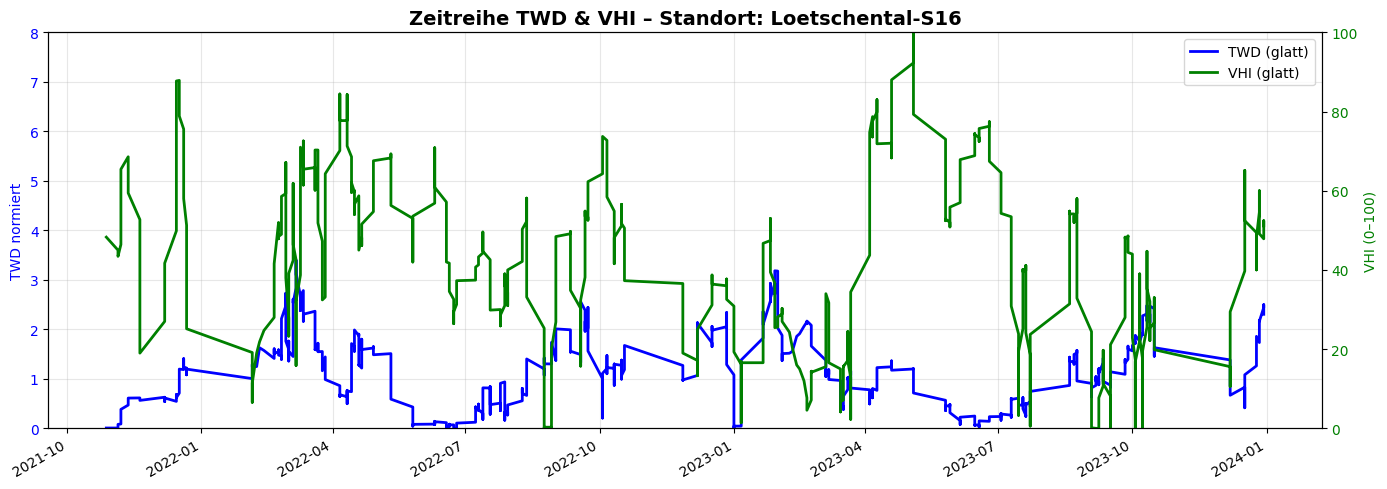

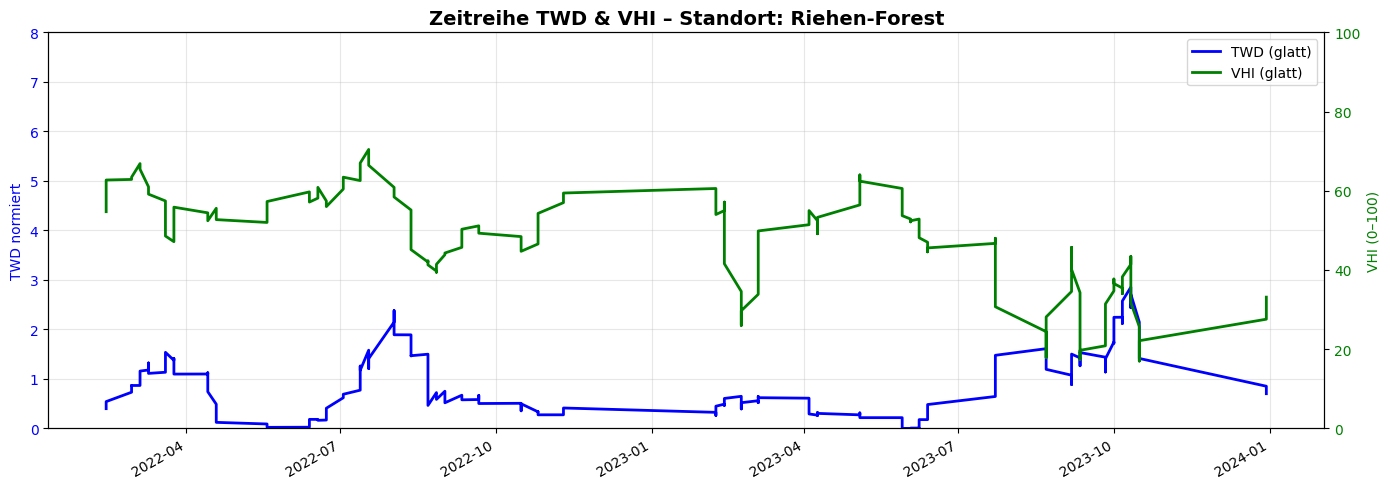

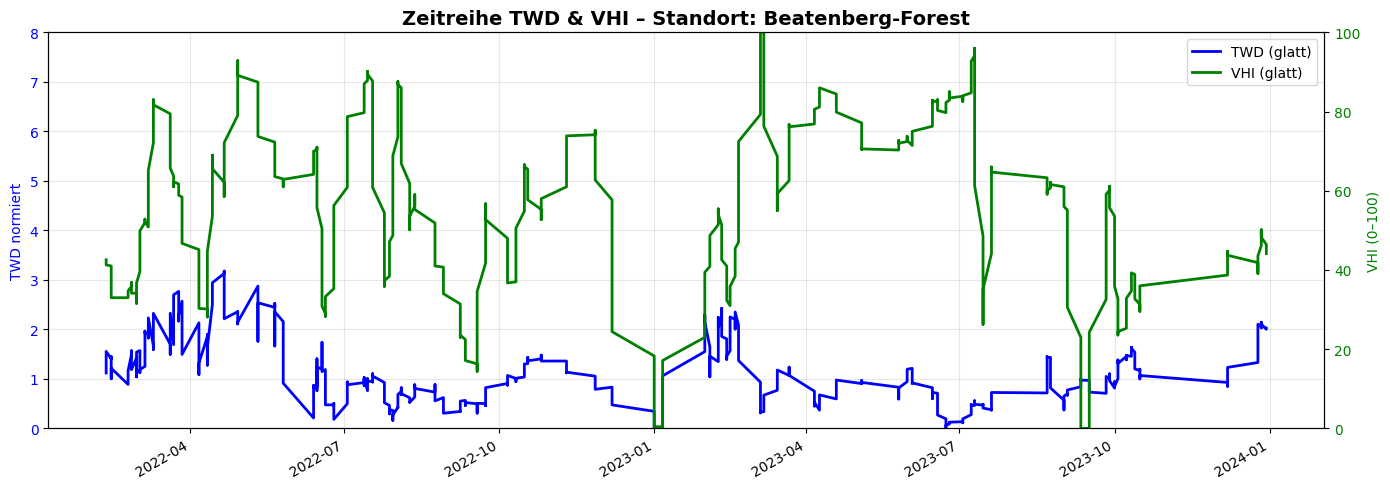

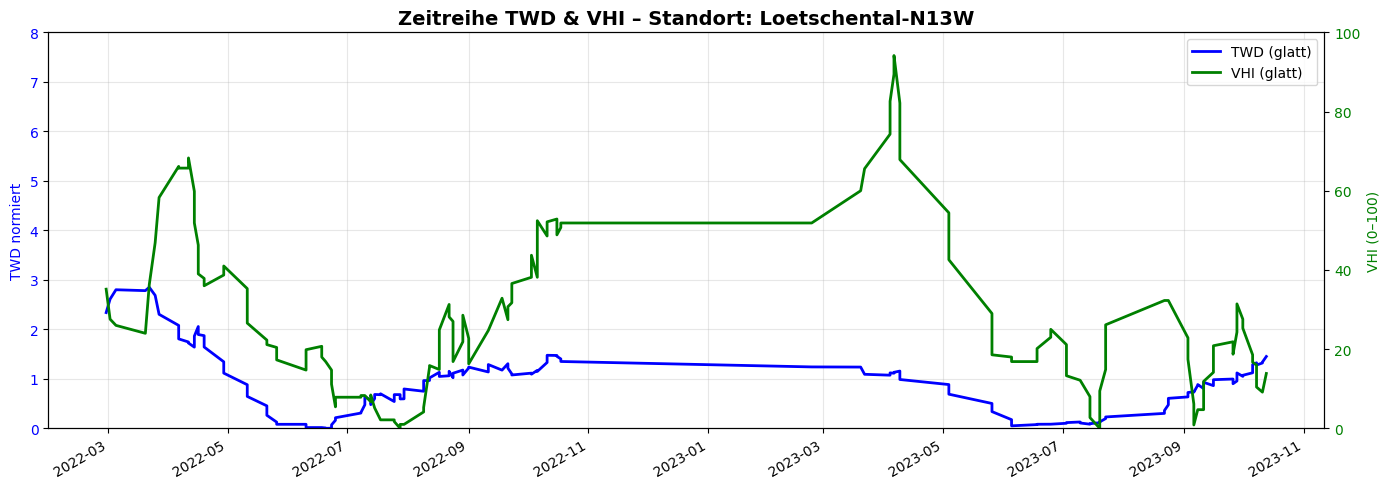

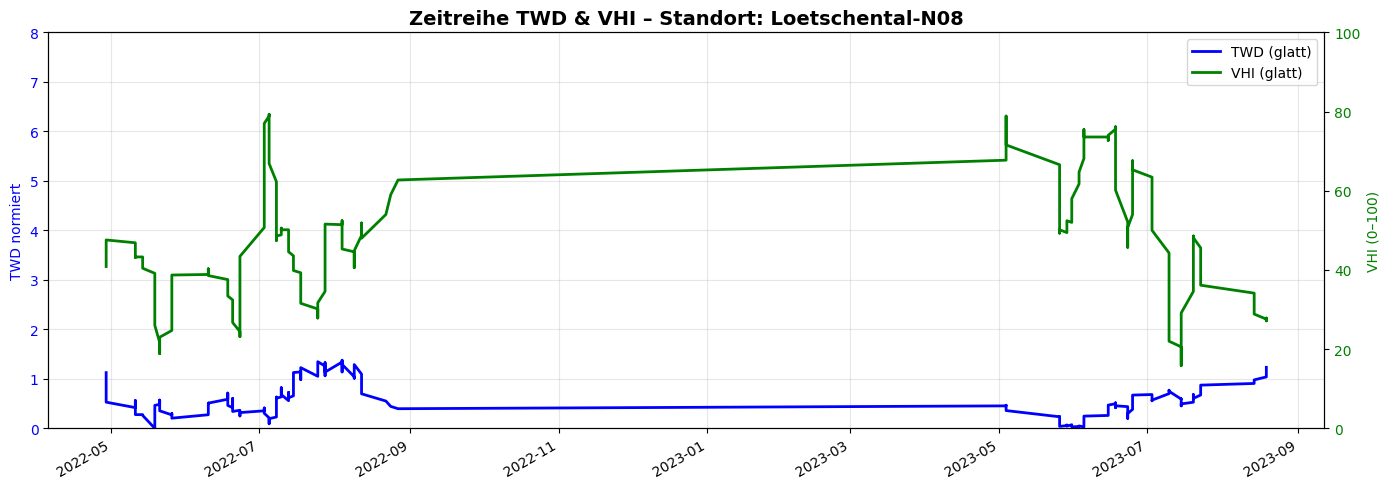

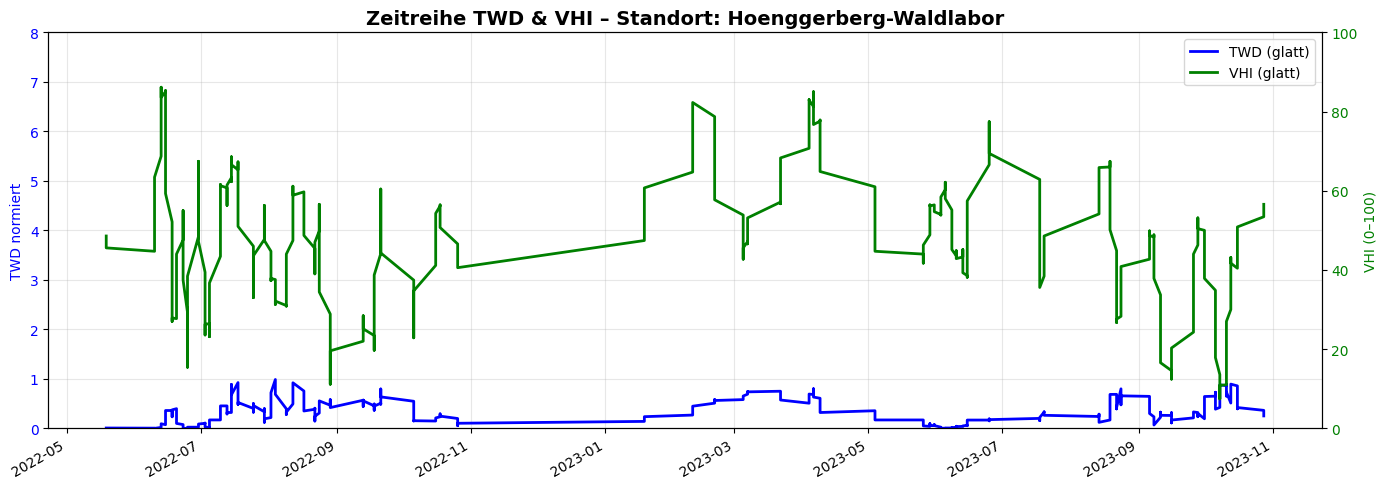

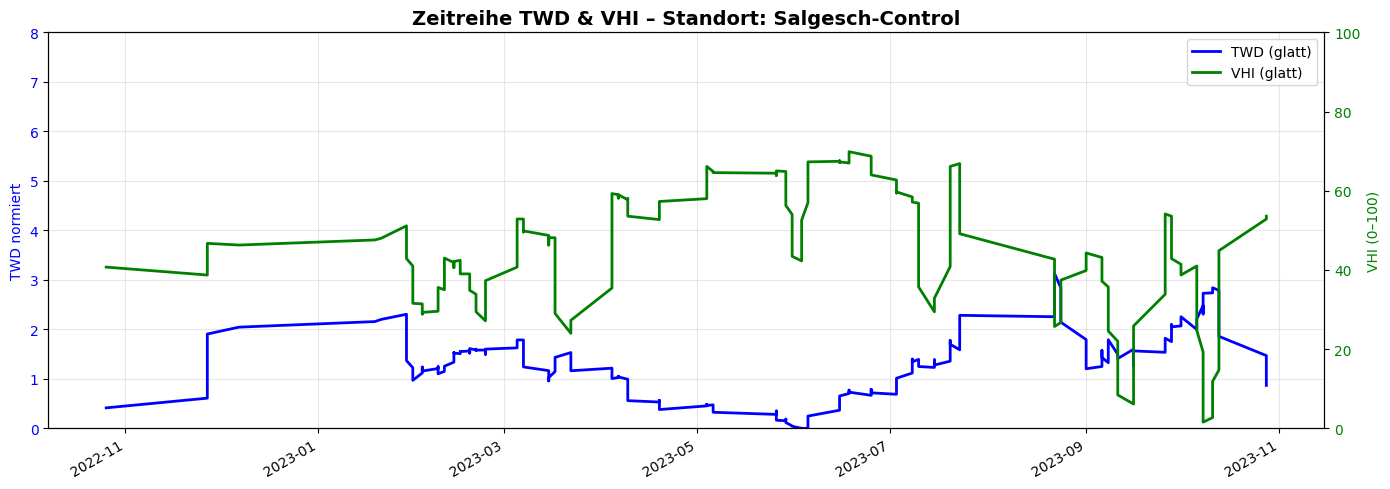

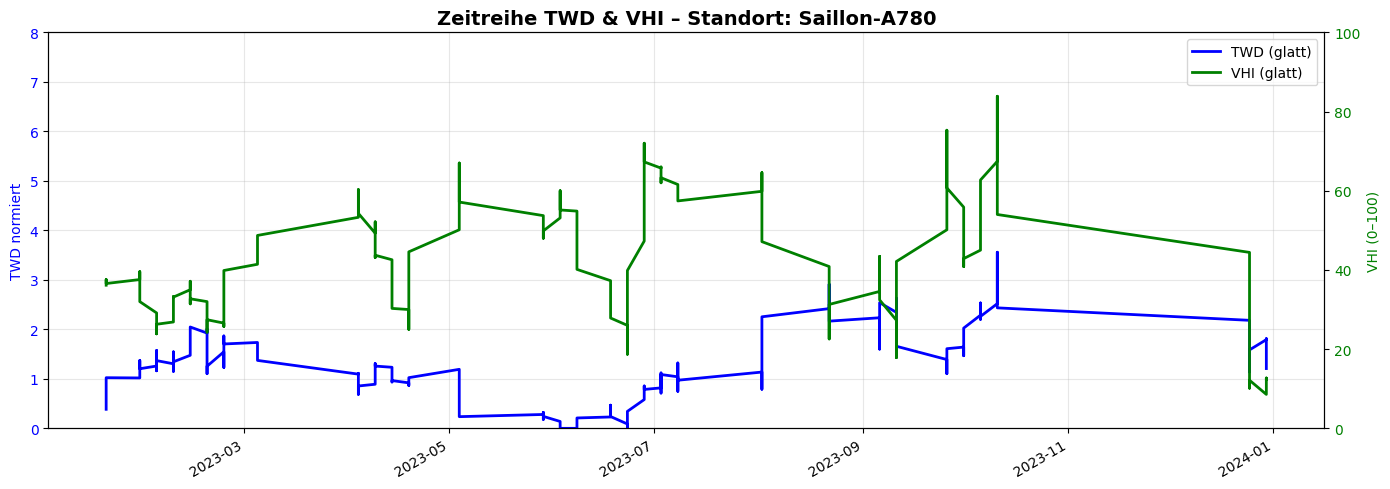

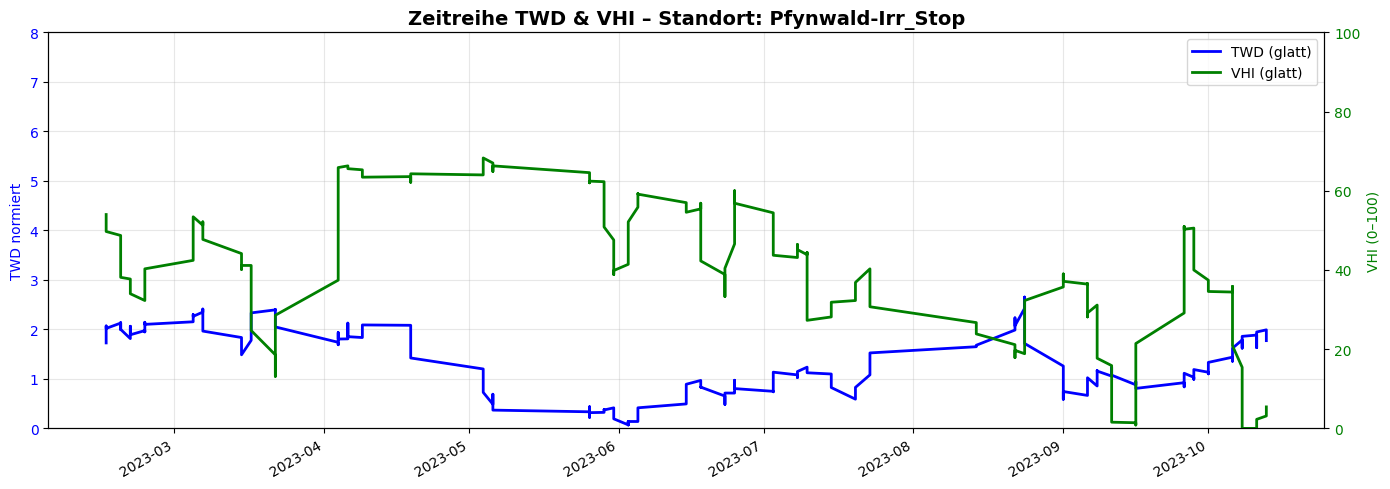

In [65]:
# Datum in datetime64 umwandeln
df_clean['date'] = pd.to_datetime(df_clean['DATETIME'], format='%Y-%m-%d')


# 2. Schleife über alle Stationen
stations = df_clean['site_name'].unique()

for station in stations:
    station_data = df_clean[df_clean['site_name'] == station].sort_values('date')

    # Rolling mean mit Fensterbreite von z.B. 7 Tagen
    station_data['twd_smooth'] = station_data['twd_norm'].rolling(window=7, center=True).mean()
    station_data['vhi_smooth'] = station_data['swissEOVHI'].rolling(window=7, center=True).mean()


    fig, ax1 = plt.subplots(figsize=(14, 5))

    # Linke Achse: TWD
    #ax1.plot(station_data['date'], station_data['twd_norm'], color='blue', label='TWD normiert', linewidth=1.5)
    # Anstelle der Rohdaten:
    ax1.plot(station_data['date'], station_data['twd_smooth'], color='blue', label='TWD (glatt)', linewidth=2)
    

    ax1.set_ylabel('TWD normiert', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(0, 8)
    ax1.grid(True, alpha=0.3)

    # Rechte Achse: VHI
    ax2 = ax1.twinx()
    #ax2.plot(station_data['date'], station_data['swissEOVHI'], color='green', label='VHI', linewidth=1.5)
    ax2.plot(station_data['date'], station_data['vhi_smooth'], color='green', label='VHI (glatt)', linewidth=2)
    ax2.set_ylabel('VHI (0–100)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim(0, 100)

    # Titel und Layout
    plt.title(f'Zeitreihe TWD & VHI – Standort: {station}', fontsize=14, fontweight='bold')
    fig.autofmt_xdate()

    # Legenden kombinieren
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    plt.tight_layout()
    plt.show()


### 11.1 Zeitreihenplot für spezifischen Standort

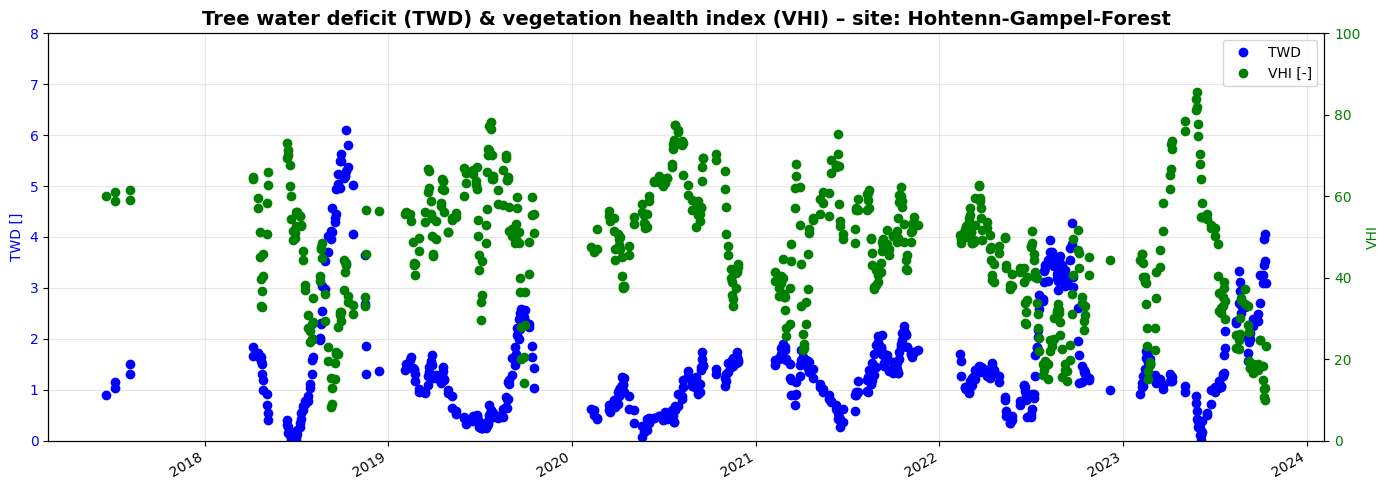

In [21]:
# Datum in datetime64 umwandeln
df_clean['date'] = pd.to_datetime(df_clean['DATETIME'], format='%Y-%m-%d')

# Wähle Station aus
station = 'Hohtenn-Gampel-Forest'
station_data = df_clean[df_clean['site_name'] == station].sort_values('date')

# Rolling mean mit Fensterbreite von z.B. 7 Tagen
station_data['twd_smooth'] = station_data['twd_norm'].rolling(window=7, center=True).mean()
station_data['vhi_smooth'] = station_data['swissEOVHI'].rolling(window=7, center=True).mean()


fig, ax1 = plt.subplots(figsize=(14, 5))

# Linke Achse: TWD
#ax1.plot(station_data['date'], station_data['twd_norm'], color='blue', label='TWD normiert', linewidth=1.5)
# Anstelle der Rohdaten:
ax1.plot(station_data['date'], station_data['twd_smooth'], 'o', color='blue', label='TWD', linewidth=2)


ax1.set_ylabel('TWD []', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 8)
ax1.grid(True, alpha=0.3)

# Rechte Achse: VHI
ax2 = ax1.twinx()
#ax2.plot(station_data['date'], station_data['swissEOVHI'], color='green', label='VHI', linewidth=1.5)
ax2.plot(station_data['date'], station_data['vhi_smooth'], 'o', color='green', label='VHI', linewidth=2)
ax2.set_ylabel('VHI [-]', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 100)

# Titel und Layout
plt.title(f'Tree water deficit (TWD) & vegetation health index (VHI) – site: {station}', fontsize=14, fontweight='bold')
fig.autofmt_xdate()

# Legenden kombinieren
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()
